# DA BALLERS - Predicting The Results of NFL Games

#### Andree Makahinda (UNI: abm2203)
#### Harshal Popat (UNI: hsp2120)
#### Adhya Rajesh (UNI: ar4279)
#### Varun Jadcherla (UNI: vrj2110)
#### Eric Loconto (UNI: el3152)

## 1. Introduction to sportsipy

#### Installing open source modules (please activate any modules that are needed to be installed)

In [1]:
!pip install sportsipy
# !pip install matplotlib
# !pip install pandas
# !pip install numpy
# !pip install datetime
# !pip install seaborn
# !pip install geojsonio --upgrade
# !pip install folium --upgrade
# !pip install ipython
# !pip install branca
# !pip install scipy
# !pip install --user decorator==4.3.0
# !pip install networkx
# !pip install scikit-learn
# !pip install xgboost
# !pip install tensorflow
# !pip install yellowbrick

# !pip install nltk
# import nltk
# nltk.download('all-corpora')

# !pip install requests
# !pip install tweepy
# !pip install gensim==3.8.3

^C


#### Importing some of the necessary packages

In [2]:
# sportsipy is an open source library to extract the game statistics
from sportsipy.nfl.boxscore import Boxscores as game_info
from sportsipy.nfl.boxscore import Boxscore as game_stats_info

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime           
%matplotlib inline

In [4]:
# To hide all the warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Increase resolutions of all the graphs in the notebook
# plt.rcParams['figure.dpi'] = 80

#### Game information and stats methods from sportsipy
1. game_info(week_number, year).games['string'] takes argument as string as 'week_number-year' format and returns a json object (having all games in that week of that year)
2. We then pull out game_id from the json object
3. game_stats_info() takes game_id (here game_str) as an argument and returns the game information

In [6]:
game_str = game_info(1,2020).games['1-2020'][0]['boxscore']
one_game_stats = game_stats_info(game_str)
one_game_stats.dataframe

You should consider upgrading via the 'C:\Users\Eric\anaconda3\python.exe -m pip install --upgrade pip' command.


,attendance,away_first_downs,away_fourth_down_attempts,away_fourth_down_conversions,away_fumbles,away_fumbles_lost,away_interceptions,away_net_pass_yards,away_pass_attempts,away_pass_completions,...,roof,stadium,surface,time,vegas_line,weather,winner,winning_abbr,winning_name,won_toss
202009100kan,15895,21,1,1,0,0,1,242,32,20,...,Outdoors,Arrowhead Stadium,Grass,8:20pm,Kansas City Chiefs -9.5,"56 degrees, relative humidity 95%, wind 7 mph",Home,KAN,Kansas City Chiefs,Chiefs (deferred)


## 2. Data Gathering and Exploration

### 2.1. Extracting the schedule of past 11 years (2010 - 2021)

Building a function using the open source sportsipy package that loops through each week and each game inside each week

In [9]:
def schedule(year):
    weeks_list = list(range(1,19))
    schedule_df = pd.DataFrame()
    for w in range(len(weeks_list)):
        date = '{}-{}'.format(weeks_list[w], year)
        w_scores = game_info(weeks_list[w],year)
        w_games_df = pd.DataFrame()
        for g in range(len(w_scores.games[date])):
            game_df = pd.DataFrame(w_scores.games[date][g], index = [0])[['away_name',
                                                                          'away_abbr',
                                                                          'home_name',
                                                                          'home_abbr',
                                                                          'winning_name',
                                                                          'winning_abbr']]
            game_df['week'] = weeks_list[w]
            w_games_df = pd.concat([w_games_df,game_df])
        schedule_df = pd.concat([schedule_df, w_games_df]).reset_index().drop(columns = 'index') 
    return schedule_df

In [11]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [ ]:
schedule(2022)

1. Importing the schedule from the year 2010 to 2020 and exporting it to a csv file (so that we don't need to extract the data from the open source, hence increasing the speed)
2. Changing names of the teams that have changed their name in the last 10 years to maintain homogeneity 
3. Concating the schedule of current year (2021) to the schedule from 2010 to 2020

In [13]:
# Setting up the current year variable and passing the number of weeks to a list
current_y = 2022
weeks_list = list(range(1,19))

In [25]:
full_schedule = pd.DataFrame()
for n in range(2010, 2022):
    schedule_ = schedule(n)
    schedule_['year'] = n
    full_schedule = pd.concat([full_schedule, schedule_])
full_schedule.reset_index(drop = True, inplace = True)

In [26]:
full_schedule = full_schedule.replace('Oakland Raiders', 'Las Vegas Raiders')
full_schedule = full_schedule.replace('San Diego Chargers', 'Los Angeles Chargers')
full_schedule = full_schedule.replace('St. Louis Rams', 'Los Angeles Rams')
full_schedule = full_schedule.replace('Washington Redskins', 'Washington Football Team')

In [28]:
full_schedule.to_csv('full_schedule2.csv')

In [29]:
full_schedule = pd.read_csv('full_schedule2.csv')
full_schedule = full_schedule.loc[:, ~full_schedule.columns.str.contains('^Unnamed')]

In [ ]:
full_schedule

In [32]:
full_schedule_1 = schedule(current_y)
full_schedule_1['year'] = current_y
full_schedule = pd.concat([full_schedule, full_schedule_1])
full_schedule.reset_index(drop = True, inplace = True)

In [33]:
completed_games_df = full_schedule[(full_schedule['winning_name'].notna()) &
                                       (full_schedule['year'] == current_y)]
    

In [ ]:
current_y


In [ ]:
completed_games_df

### CHANGING CODE TO ADJUST FOR 2022

In [34]:
if completed_games_df.empty:
    latest_completed_w = 1
else:
    latest_completed_w = completed_games_df.values.max()

scheduled_games_df = full_schedule[(full_schedule['winning_name'].isnull()) &
                                           (full_schedule['year'] == current_y) &
                                           (full_schedule['week'] >= latest_completed_w)]

In [ ]:
latest_completed_w

In [ ]:
scheduled_games_df

### 2.2. Setting up the current week
1. Current week (current_w) is the most important argument (parameter) in the functions
2. We should make sure that the current_w really matches the real current week of the NFL season while also considering whether or not the library has updated its database
3. We have run our code and built our model in the week 14 of 2021 NFL season (Dec 12, 09.00 AM)
4. In other words, all the visualizations, analysis, model accuracy, model selection, presentation, and report all have been produced from running the code on that time 
5. Our model is an adapting model, meaning that it will adapt and take into accounts the new available data (the new games that just been played during the current week)
6. Please note that the results may be changed and different from our submission (presentation and report) if the code is being run again after our submission time since the current week and data may be updated by the library developer
7. The results may also be changed even when the current week is still the same if there are new game data that are being updated in the database

In [35]:
# Using full_schedule method to determine the correct current week as an input
def determine_current_week(full_schedule, current_y):
    current_w = int()
    completed_games_df = full_schedule[(full_schedule['winning_name'].notna()) &
                                       (full_schedule['year'] == current_y)]
    
    if len(completed_games_df) == 0:
        current_w = 1
    else:
        latest_completed_w = completed_games_df['week'].values.max()
        scheduled_games_df = full_schedule[(full_schedule['winning_name'].isnull()) &
                                           (full_schedule['year'] == current_y) &
                                           (full_schedule['week'] >= latest_completed_w)]
#         if scheduled_games_df.empty:
#             earliest_scheduled_w = 1
#         else:
#             latest_completed_w = completed_games_df.values.max()

        earliest_scheduled_w = scheduled_games_df['week'].values.min()
        #print(completed_games_df)
        current_w = earliest_scheduled_w
    
    print('The current week is: ', current_w)
    
    return current_w

In [ ]:
# Setting up the current week
current_w = determine_current_week(full_schedule, current_y)
print('The current week value being assigned: ', current_w)

### 2.3. Full schedule dataframe exploration

In [ ]:
full_schedule.head()

In [ ]:
full_schedule.tail()

In [ ]:
full_schedule.info()

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [19]:
full_schedule_null = full_schedule[full_schedule['winning_name'].isnull()]
len(full_schedule_null)

282

In [ ]:
full_schedule_null

In [ ]:
full_schedule = full_schedule.drop_duplicates()

In [ ]:
full_schedule

1. We can see that there are two columns that contain null values: winning_name and winning_abbr
2. There are 87 null values
3. The null values consists of NaN and None
4. NaN = The result of the game is a draw -> to be handled (excluded) later
5. None = The match (or game) has not completed yet, only scheduled

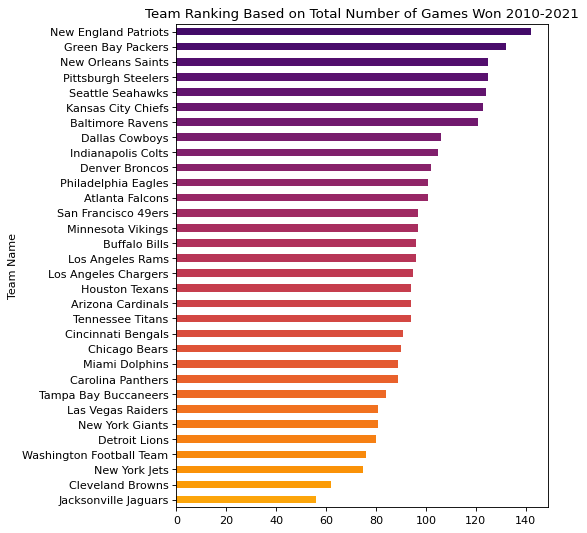

In [36]:
# We can find which team recorded the most wins from 2010 up until now
def plot_team_rank_based_on_winning_count(full_schedule):
    winner_group = full_schedule.groupby('winning_name')
    from matplotlib import cm
    plt.rcParams["figure.dpi"] = 80
    colors = cm.inferno_r(np.linspace(.2, .8, 32))
    winner_group.size().sort_values().plot(kind='barh', figsize=(6,8), xlabel='Team Name',
        title='Team Ranking Based on Total Number of Games Won 2010-2021', color=colors)

plot_team_rank_based_on_winning_count(full_schedule)

1. Team with the most wins is New England Patriots, followed by Green Bay Packers and Pittsburgh Steelers
2. On the other hand, team with the least wins is Jacksonville Jaguars, followed by Cleveland Browns and New York Jets
3. We can create the same chart but only for a specific year (cross-section analysis)
4. For example, in 2020, the team with the most wins is Kansas City Chiefs, followed by Buffalo Bills and Green Bay Packers

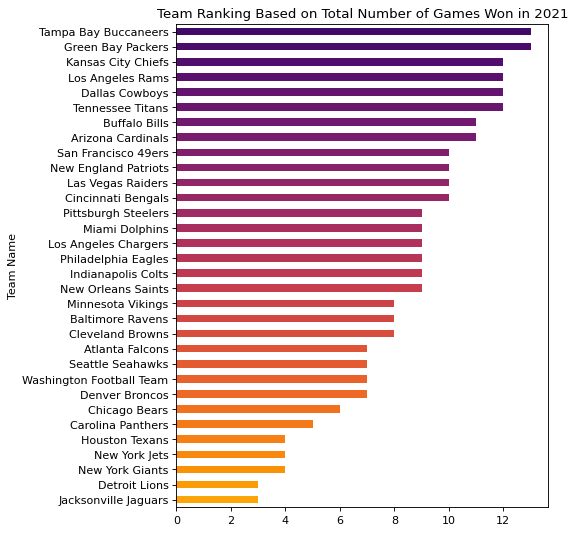

In [37]:
# Find the team with the most wins in a given year
def plot_team_rank_for_specific_year(full_schedule, year):
    full_schedule_filtered = full_schedule[full_schedule['year'] == year]
    winner_group = full_schedule_filtered.groupby('winning_name')
    from matplotlib import cm
    plt.rcParams["figure.dpi"] = 80
    colors = cm.inferno_r(np.linspace(.2, .8, 32))
    winner_group.size().sort_values().plot(kind='barh', figsize=(6,8), x='Games Won', xlabel='Team Name',
        title=f'Team Ranking Based on Total Number of Games Won in {year}', color=colors)

plot_team_rank_for_specific_year(full_schedule, 2021)

Team,Arizona Cardinals,Atlanta Falcons,Baltimore Ravens,Buffalo Bills,Carolina Panthers,Chicago Bears,Cincinnati Bengals,Cleveland Browns,Dallas Cowboys,Denver Broncos,Detroit Lions,Green Bay Packers,Houston Texans,Indianapolis Colts,Jacksonville Jaguars,Kansas City Chiefs,Las Vegas Raiders,Los Angeles Chargers,Los Angeles Rams,Miami Dolphins,Minnesota Vikings,New England Patriots,New Orleans Saints,New York Giants,New York Jets,Philadelphia Eagles,Pittsburgh Steelers,San Francisco 49ers,Seattle Seahawks,Tampa Bay Buccaneers,Tennessee Titans,Washington Football Team
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010,5.0,13.0,13.0,4.0,2.0,11.0,4.0,5.0,6.0,4.0,6.0,11.0,6.0,10.0,8.0,10.0,8.0,9.0,7.0,7.0,6.0,14.0,11.0,10.0,12.0,10.0,12.0,6.0,8.0,10.0,6.0,6.0
2011,8.0,10.0,12.0,6.0,6.0,8.0,9.0,4.0,8.0,9.0,10.0,15.0,11.0,2.0,5.0,7.0,8.0,8.0,2.0,6.0,3.0,13.0,14.0,10.0,8.0,8.0,12.0,13.0,7.0,4.0,9.0,5.0
2012,5.0,13.0,11.0,6.0,7.0,10.0,10.0,5.0,8.0,13.0,4.0,12.0,13.0,11.0,2.0,2.0,4.0,7.0,7.0,7.0,10.0,12.0,7.0,9.0,6.0,4.0,8.0,11.0,12.0,7.0,6.0,10.0
2013,10.0,4.0,8.0,6.0,12.0,8.0,11.0,4.0,8.0,13.0,7.0,8.0,2.0,12.0,4.0,11.0,4.0,10.0,7.0,8.0,5.0,12.0,12.0,7.0,8.0,10.0,8.0,13.0,13.0,4.0,7.0,3.0
2014,11.0,6.0,11.0,9.0,8.0,5.0,10.0,7.0,13.0,12.0,11.0,12.0,9.0,12.0,3.0,9.0,3.0,9.0,6.0,8.0,7.0,12.0,7.0,6.0,4.0,10.0,11.0,8.0,12.0,2.0,2.0,4.0
2015,13.0,8.0,5.0,8.0,15.0,6.0,12.0,3.0,4.0,12.0,7.0,11.0,9.0,8.0,5.0,12.0,7.0,4.0,7.0,6.0,11.0,12.0,7.0,6.0,10.0,7.0,11.0,5.0,11.0,6.0,3.0,9.0
2016,7.0,11.0,8.0,7.0,6.0,3.0,6.0,1.0,13.0,9.0,9.0,11.0,10.0,8.0,3.0,12.0,12.0,5.0,4.0,10.0,8.0,14.0,7.0,11.0,5.0,7.0,12.0,2.0,11.0,9.0,9.0,8.0
2017,8.0,11.0,9.0,9.0,11.0,5.0,7.0,0.0,9.0,5.0,9.0,7.0,4.0,4.0,11.0,10.0,6.0,9.0,11.0,6.0,13.0,13.0,12.0,3.0,5.0,13.0,13.0,6.0,9.0,5.0,10.0,7.0
2018,3.0,7.0,10.0,6.0,7.0,12.0,6.0,7.0,11.0,6.0,6.0,6.0,11.0,11.0,5.0,12.0,4.0,13.0,13.0,7.0,8.0,11.0,13.0,5.0,4.0,10.0,9.0,4.0,10.0,5.0,9.0,7.0


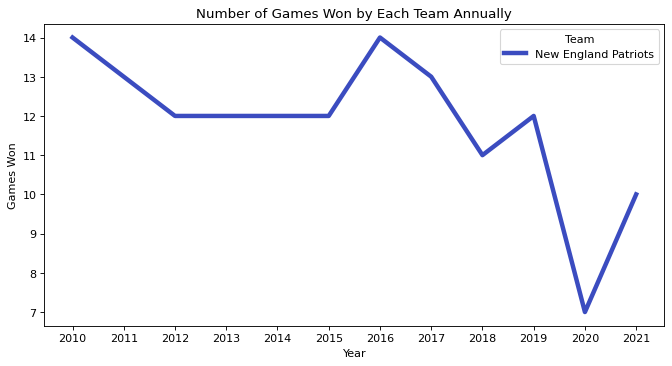

In [38]:
# We can also find out how each team performs each year (time-series)
def plot_team_performance(full_schedule, team_names):
    team_performance_df = full_schedule.groupby(['winning_name','year']).size().unstack().T
    team_performance_df = team_performance_df.fillna(0)
    team_performance_df.columns.name = 'Team'
    plt.rcParams["figure.dpi"] = 80
    team_performance_df.loc[:,team_names].plot(figsize=(10,5), grid=False, xlabel='Year',
        ylabel='Games Won', xticks = team_performance_df.index, colormap='coolwarm',
        lw=4, title='Number of Games Won by Each Team Annually')
    return team_performance_df

team_names = ['New England Patriots']
plot_team_performance(full_schedule, team_names)

1. As seen above, even though New England Patriots recorded the most wins in the last 10 years, its performance was not that good last year
2. Using the same function, we can compare the trend for several teams in one graph like the one below

Team,Arizona Cardinals,Atlanta Falcons,Baltimore Ravens,Buffalo Bills,Carolina Panthers,Chicago Bears,Cincinnati Bengals,Cleveland Browns,Dallas Cowboys,Denver Broncos,Detroit Lions,Green Bay Packers,Houston Texans,Indianapolis Colts,Jacksonville Jaguars,Kansas City Chiefs,Las Vegas Raiders,Los Angeles Chargers,Los Angeles Rams,Miami Dolphins,Minnesota Vikings,New England Patriots,New Orleans Saints,New York Giants,New York Jets,Philadelphia Eagles,Pittsburgh Steelers,San Francisco 49ers,Seattle Seahawks,Tampa Bay Buccaneers,Tennessee Titans,Washington Football Team
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010,5.0,13.0,13.0,4.0,2.0,11.0,4.0,5.0,6.0,4.0,6.0,11.0,6.0,10.0,8.0,10.0,8.0,9.0,7.0,7.0,6.0,14.0,11.0,10.0,12.0,10.0,12.0,6.0,8.0,10.0,6.0,6.0
2011,8.0,10.0,12.0,6.0,6.0,8.0,9.0,4.0,8.0,9.0,10.0,15.0,11.0,2.0,5.0,7.0,8.0,8.0,2.0,6.0,3.0,13.0,14.0,10.0,8.0,8.0,12.0,13.0,7.0,4.0,9.0,5.0
2012,5.0,13.0,11.0,6.0,7.0,10.0,10.0,5.0,8.0,13.0,4.0,12.0,13.0,11.0,2.0,2.0,4.0,7.0,7.0,7.0,10.0,12.0,7.0,9.0,6.0,4.0,8.0,11.0,12.0,7.0,6.0,10.0
2013,10.0,4.0,8.0,6.0,12.0,8.0,11.0,4.0,8.0,13.0,7.0,8.0,2.0,12.0,4.0,11.0,4.0,10.0,7.0,8.0,5.0,12.0,12.0,7.0,8.0,10.0,8.0,13.0,13.0,4.0,7.0,3.0
2014,11.0,6.0,11.0,9.0,8.0,5.0,10.0,7.0,13.0,12.0,11.0,12.0,9.0,12.0,3.0,9.0,3.0,9.0,6.0,8.0,7.0,12.0,7.0,6.0,4.0,10.0,11.0,8.0,12.0,2.0,2.0,4.0
2015,13.0,8.0,5.0,8.0,15.0,6.0,12.0,3.0,4.0,12.0,7.0,11.0,9.0,8.0,5.0,12.0,7.0,4.0,7.0,6.0,11.0,12.0,7.0,6.0,10.0,7.0,11.0,5.0,11.0,6.0,3.0,9.0
2016,7.0,11.0,8.0,7.0,6.0,3.0,6.0,1.0,13.0,9.0,9.0,11.0,10.0,8.0,3.0,12.0,12.0,5.0,4.0,10.0,8.0,14.0,7.0,11.0,5.0,7.0,12.0,2.0,11.0,9.0,9.0,8.0
2017,8.0,11.0,9.0,9.0,11.0,5.0,7.0,0.0,9.0,5.0,9.0,7.0,4.0,4.0,11.0,10.0,6.0,9.0,11.0,6.0,13.0,13.0,12.0,3.0,5.0,13.0,13.0,6.0,9.0,5.0,10.0,7.0
2018,3.0,7.0,10.0,6.0,7.0,12.0,6.0,7.0,11.0,6.0,6.0,6.0,11.0,11.0,5.0,12.0,4.0,13.0,13.0,7.0,8.0,11.0,13.0,5.0,4.0,10.0,9.0,4.0,10.0,5.0,9.0,7.0


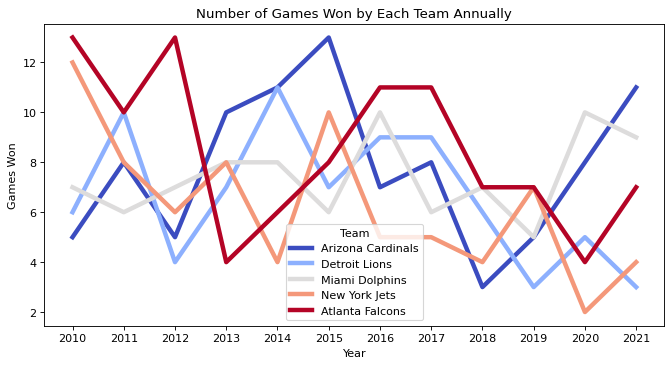

In [39]:
team_names = ['Arizona Cardinals','Detroit Lions','Miami Dolphins','New York Jets','Atlanta Falcons']
plot_team_performance(full_schedule, team_names)

1. Another time-series analysis we can do with the full schedule dataframe is comparing the number of wins between away and home team
2. From the graph below, we can see that home team scored more wins from 2010 to 2019
3. In 2020, however, away team managed to record more wins
4. The season is still on-going for the 2021 NFL but away team is currently leading the metric

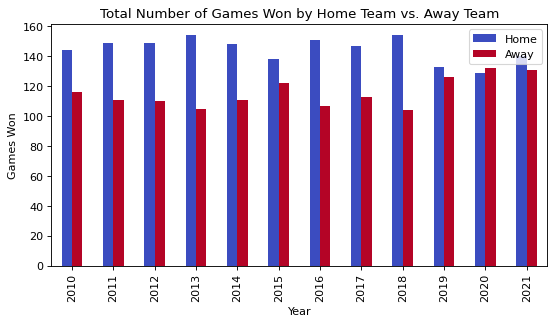

In [40]:
# We can check how many times a home team wins vs an away team wins each year
def plot_home_vs_away(full_schedule):
    home_team_wins_df = full_schedule[full_schedule['winning_name']==full_schedule['home_name']]
    home_team_wins_df = pd.DataFrame(home_team_wins_df.groupby('year').size())
    away_team_wins_df = full_schedule[full_schedule['winning_name']==full_schedule['away_name']]
    away_team_wins_df = pd.DataFrame(away_team_wins_df.groupby('year').size())
    combined_df = pd.merge(home_team_wins_df, away_team_wins_df, left_index=True, right_index=True)
    combined_df = combined_df.rename(columns = {'0_x':'Home','0_y':'Away'})
    plt.rcParams["figure.dpi"] = 80
    combined_df.plot(kind ='bar',figsize=(8,4), grid=False, xlabel='Year', ylabel='Games Won',
                    title='Total Number of Games Won by Home Team vs. Away Team',
                    colormap='coolwarm')

plot_home_vs_away(full_schedule)

### 2.4. Extracting the game data (stats) of past 11 years (2010 - 2021)

#### Column manipulation functions

Creating the supporting functions that will help the main functions for ease of processing

In [41]:
# 'column_name_manipulation' function changes the feature names (it removes home/away from the start of the feature name)
def column_name_manipulation(obj):
    if type(obj) is not list:
        columns =  list(obj.columns)
    else:
        columns =  obj
    new_columns_list = []

    for column_name in columns:
        if 'away' in column_name:
            column_name = column_name.split('_')
            column_name.remove('away')
            column_name = column_name = '_'.join(column_name)
            new_columns_list.append(column_name)
            
        elif 'home' in column_name:
            column_name = column_name.split('_')
            column_name.remove('home')
            column_name = column_name = '_'.join(column_name)
            new_columns_list.append(column_name)
            
        else:
            new_columns_list.append(column_name)
    if type(obj) is not list:
        obj.columns = new_columns_list
    else:       
        obj = new_columns_list
        
    return obj

In [42]:
# 'column_name_manipulation' function changes the feature names (it adds home/away from the start of the feature name)
def column_name_manipulation_reverse(obj, type_ = 'home'):
    if type(obj) is not list:
        columns =  list(obj.columns)
    else:
        columns =  obj
        
    new_columns_list = []

    for column_name in columns:
        column_name = type_ + '_' + column_name 
        new_columns_list.append(column_name)
            
    if type(obj) is not list:
        obj.columns = new_columns_list
    else:       
        obj = new_columns_list
        
    return obj

1. Dropping the redundant columns
2. Listing the required columns

In [43]:
columns_required = ['first_downs', 'fourth_down_attempts', 'fourth_down_conversions', 
                    'fumbles', 'fumbles_lost', 'interceptions','net_pass_yards',
                    'pass_attempts','pass_completions','pass_touchdowns','pass_yards',
                    'penalties','points','rush_attempts','rush_touchdowns','rush_yards',
                    'third_down_attempts','third_down_conversions','time_of_possession',
                    'times_sacked','total_yards','turnovers','yards_from_penalties','yards_lost_from_sacks']

#### Function to extract each game info

1. 'g_data' function takes 2 arguments as inputs, schedule and game info
2. It returns 2 dataframes, home_df and away_df
3. home_df and away_df contain statistics of home team and away team for that particular game
4. It also adds 2 more columns to the dataframes, game_won and game_lost, which are binary. If score of away team is greater than home team, that means away team won and hence away_df would have game_won flagged as 1 and game_lost flagged as 0. Same for home team.
5. The prefixes home/away are removed from each of the dataframe features
6. We do (5) to build past records of each team for each game and use it for modelling and analyses
7. The function also transforms the value of time_of_possession from a time duration format (%M:%S) to integer duration (expressed in seconds)

In [44]:
def g_data(g_df,one_game_stats):

    columns_required_home = column_name_manipulation_reverse(columns_required, 'home')
    columns_required_away = column_name_manipulation_reverse(columns_required, 'away')
    
    try:
        a_team_df = column_name_manipulation(g_df[['away_name', 'away_abbr', 'away_score']]).rename(columns = {
            'name' : 'team_name', 'abbr': 'team_abbr'})
        h_team_df = column_name_manipulation(g_df[['home_name','home_abbr', 'home_score']]).rename(columns = {
            'name' : 'team_name', 'abbr': 'team_abbr'})

        try:
            if g_df.loc[0,'away_score'] != g_df.loc[0,'home_score']:
                a_team_df['game_won'] = int(g_df.loc[0,'away_score'] > g_df.loc[0,'home_score'])
                a_team_df['game_lost'] = 1- a_team_df['game_won']
                h_team_df['game_won'] = int(g_df.loc[0,'away_score'] < g_df.loc[0,'home_score'])
                h_team_df['game_lost'] = 1- h_team_df['game_won']

            else:
                a_team_df['game_won'] = a_team_df['game_lost'] = h_team_df['game_won'] = h_team_df['game_lost'] = 0

        except TypeError:
                a_team_df['game_won'] = a_team_df['game_lost'] = h_team_df['game_won'] = h_team_df['game_lost'] = np.nan
                
        a_stats_df = one_game_stats.dataframe[columns_required_away].reset_index().drop(columns ='index')
        a_stats_df = column_name_manipulation(a_stats_df)
        
        h_stats_df = one_game_stats.dataframe[columns_required_home].reset_index().drop(columns = 'index')
        h_stats_df = column_name_manipulation(h_stats_df)

        a_team_df = pd.merge(a_team_df, a_stats_df,left_index = True, right_index = True)
        h_team_df = pd.merge(h_team_df, h_stats_df,left_index = True, right_index = True)
        
        try:
            time_a_team = datetime.datetime.strptime(a_team_df['time_of_possession'][0],'%M:%S')
            time_h_team = datetime.datetime.strptime(h_team_df['time_of_possession'][0],'%M:%S')
            a_team_df['time_of_possession'] = int(time_a_team.minute* 60) + int(time_a_team.second)
            h_team_df['time_of_possession'] = int(time_h_team.minute* 60) + int(time_h_team.second)
        except TypeError:
            a_team_df['time_of_possession'] = np.nan
            h_team_df['time_of_possession'] = np.nan
            
    except TypeError:
        a_team_df = pd.DataFrame()
        h_team_df = pd.DataFrame()
    return a_team_df, h_team_df

In [63]:
week_scores = game_info(2,2021)
game_str = week_scores.games['2-2022'][0]['boxscore']
one_game_stats = game_stats_info(game_str)
g_df = pd.DataFrame(week_scores.games['2-2021'][0], index = [0])
g_data(g_df,one_game_stats)[0]
game_str

KeyError: '2-2022'

#### Apply g_data function in for loop to gather all the game statistics given number of weeks and year number

1. g_data_till_week function takes 2 arguments : weeks_list and year (weeks_list is the list of all the weeks for which we want data) 
2. It returns team statistics for each game in that particular week for that particular year
3. In our case, we take data for all the weeks in a season 

In [58]:
def g_data_till_week(weeks_list, year):
    weeksgames_df = pd.DataFrame()
    for w in range(len(weeks_list)):
        date = '{}-{}'.format(weeks_list[w], year)
        w_scores = game_info(weeks_list[w],year)
        print(w_scores)
        w_games_df = pd.DataFrame()
        for g in range(len(w_scores.games[date])):
            game_string = w_scores.games[date][g]['boxscore']
            one_game_stats = game_stats_info(game_string)
            g_df = pd.DataFrame(w_scores.games[date][g], index = [0])
            a_team_df, h_team_df = g_data(g_df,one_game_stats)
            a_team_df['week'] = h_team_df['week'] = weeks_list[w]
            w_games_df = pd.concat([w_games_df,a_team_df])
            w_games_df = pd.concat([w_games_df,h_team_df])
        weeksgames_df = pd.concat([weeksgames_df,w_games_df])
    return weeksgames_df

In [60]:
weeksgames_df

NameError: name 'weeksgames_df' is not defined

In [61]:
g_data_till_week(weeks_list, 2021)

NFL games for week 1
NFL games for week 2
NFL games for week 3
NFL games for week 4
NFL games for week 5
NFL games for week 6
NFL games for week 7
NFL games for week 8
NFL games for week 9
NFL games for week 10
NFL games for week 11
NFL games for week 12
NFL games for week 13
NFL games for week 14
NFL games for week 15
NFL games for week 16
NFL games for week 17
NFL games for week 18


,team_name,team_abbr,score,game_won,game_lost,first_downs,fourth_down_attempts,fourth_down_conversions,fumbles,fumbles_lost,interceptions,net_pass_yards,pass_attempts,pass_completions,pass_touchdowns,pass_yards,penalties,points,rush_attempts,rush_touchdowns,rush_yards,third_down_attempts,third_down_conversions,time_of_possession,times_sacked,total_yards,turnovers,yards_from_penalties,yards_lost_from_sacks,week
0,Dallas Cowboys,dal,29,0,1,30,0,0,1,0,1,391,58,42,3,403,8,29,18,0,60,17,9,2067,1,451,1,55,12,1
0,Tampa Bay Buccaneers,tam,31,1,0,24,0,0,2,2,2,379,50,32,4,379,11,31,14,0,52,11,5,1533,0,431,4,106,0,1
0,Philadelphia Eagles,phi,32,1,0,24,2,0,2,0,0,261,35,27,3,264,14,32,31,1,173,13,6,1862,1,434,0,89,3,1
0,Atlanta Falcons,atl,6,0,1,19,3,1,1,0,0,136,35,21,0,164,12,6,26,0,124,14,3,1738,3,260,0,99,28,1
0,Pittsburgh Steelers,pit,23,1,0,16,0,0,1,0,0,177,32,18,1,188,5,23,21,0,75,12,4,1603,2,252,0,32,11,1
0,Buffalo Bills,buf,16,0,1,22,3,1,4,1,0,254,51,30,1,270,8,16,25,0,117,18,8,1997,3,371,1,81,16,1
0,New York Jets,nyj,14,0,1,16,2,1,1,0,1,207,37,20,2,258,5,14,17,0,45,13,4,1720,6,252,1,30,51,1
0,Carolina Panthers,car,19,1,0,18,1,0,1,1,0,270,35,24,1,279,6,19,27,1,111,14,4,1880,1,381,1,38,9,1
0,Minnesota Vikings,min,24,0,1,24,2,2,1,1,0,336,50,37,2,362,12,24,22,1,67,16,6,2109,3,403,1,116,26,1
0,Cincinnati Bengals,cin,27,1,0,20,3,2,0,0,0,217,27,20,2,261,3,27,36,1,149,14,3,2091,5,366,0,15,44,1


In [ ]:
game_info(weeks_list[3],2022).games['4-2022'][0]['boxscore']

1. Importing the team statistics for each game from the year 2010 to 2020 using the g_data function and exporting it to a csv file (so that we don't need to extract the data from the open source, hence increasing the speed)
2. Changing names of the teams that have changed their name in the last 10 years to maintain homogeneity 
3. Concating the team statistics for each game of the current year (2021) to the similar team stats from 2010 to 2020

In [49]:
full_game_data = pd.DataFrame()
for n in range(2020, 2022):
    game_data_ = g_data_till_week(list(range(1, 18)), n)
    game_data_['year'] = n
    full_game_data = pd.concat([full_game_data, game_data_])
full_game_data.reset_index(drop = True, inplace = True)

In [51]:
full_game_data = full_game_data.replace('Oakland Raiders', 'Las Vegas Raiders')
full_game_data = full_game_data

In [52]:
full_game_data.to_csv('full_game_data3.csv')

In [53]:
full_game_data = pd.read_csv('full_game_data2.csv')
full_game_data = full_game_data.loc[:, ~full_game_data.columns.str.contains('^Unnamed')]

### HAD TO HARD CODE 2021 IN, SUPPOSED TO BE 2022, WHY DOESNT THIS WORK?

In [64]:
full_game_data_1 = g_data_till_week(weeks_list, 2021)
full_game_data_1['year'] = 2021
full_game_data = pd.concat([full_game_data, full_game_data_1])
full_game_data.reset_index(drop = True, inplace = True)

NFL games for week 1
NFL games for week 2
NFL games for week 3
NFL games for week 4
NFL games for week 5
NFL games for week 6
NFL games for week 7
NFL games for week 8
NFL games for week 9
NFL games for week 10
NFL games for week 11
NFL games for week 12
NFL games for week 13
NFL games for week 14
NFL games for week 15
NFL games for week 16
NFL games for week 17
NFL games for week 18


In [ ]:
full_game_data=full_game_data.drop_duplicates()

### 2.5. Full game data (stats) dataframe exploration

In [ ]:
full_game_data.head()

In [ ]:
full_game_data.tail()

In [ ]:
full_game_data.info()

1. We can see that the team stats data from sportsipy NFL package are complete (no null/missing values)
2. There are also no duplicate values (as indicated below) since each row is attributed to each team's performance for a specific match
2. This dataframe is not the final dataframe that will be used in the machine learning application
3. However, we can analyze and extract some insights from this dataframe before creating the final dataframe

In [ ]:
full_game_data.duplicated().unique()

In [ ]:
# We first can do a single variable (univariat) analysis by plotting its histogram
# Since the game is played with each team trying to score to win, we'll use this variable
def create_histogram_for_one_variable(full_game_data, variable_name):
    full_game_data[variable_name].hist(bins=15, figsize=(5,4), grid=False, color='midnightblue')
    plt.xlabel(variable_name)
    plt.ylabel('Frequency')
    plt.title('Histogram of ' + variable_name)
    print(variable_name)

variable_name = 'score'
create_histogram_for_one_variable(full_game_data, variable_name)

1. We can see that it's not that balanced and there are some extremes to the right side
3. From the histogram, we can conclude that the teams usually score between 15-30
2. The data also shows that there are less and less observations when a team scores more than 40 in a match

In [ ]:
# We can further stack the histogram by the year
def create_stacked_histogram_for_one_variable(full_game_data, variable_name):
    from matplotlib import cm
    colors = cm.inferno_r(np.linspace(.3, .7, 12))
    full_game_data.pivot(columns='year')['score'].plot(kind = 'hist', bins = 15,
                                                       figsize=(5,4), grid=False,
                                                       stacked=True, color=colors)
    plt.xlabel(variable_name)
    plt.ylabel('Frequency')
    plt.title('Histogram of ' + variable_name + ' Grouped by Year')

variable_name = 'score'
create_stacked_histogram_for_one_variable(full_game_data, variable_name)

1. From the graph above, we see that there is no significant difference between each year in each bar
2. The frequency tends to be divided fairly every season
3. It may be easier to see the cumulative histogram to see that the height of each bar is fairly divided

In [ ]:
# We can plot the cumulative histogram of the above graph
def create_stacked_histogram_for_one_variable_cumulative(full_game_data, variable_name):
    from matplotlib import cm
    colors = cm.inferno_r(np.linspace(.3, .7, 12))
    full_game_data.pivot(columns='year')['score'].plot(kind = 'hist', bins = 15,
                                                       figsize=(5,5), grid=False,
                                                       stacked=True, color=colors,
                                                       cumulative=True)
    plt.xlabel(variable_name)
    plt.ylabel('Frequency')
    plt.title('Cumulative Histogram of ' + variable_name + ' Grouped by Year')

variable_name = 'score'
create_stacked_histogram_for_one_variable_cumulative(full_game_data, variable_name)

In [ ]:
# We are interested in the relationship between the score and all other team stats
def plot_scatter_for_score_vs_other_stats(full_game_data, no_of_cols):
    team_stats = full_game_data.drop(columns = ['team_name', 'team_abbr', 'game_won',
                                            'game_lost', 'week', 'year'])
    no_of_rows = (len(team_stats.columns)//no_of_cols)+1
    fig = plt.figure(figsize=(20,30))
    for i, col in enumerate(team_stats.iloc[:,1:].columns):
        ax = fig.add_subplot(no_of_rows,no_of_cols, i+1)
        ax.scatter(team_stats[col], team_stats['score'], c='dimgrey')
        ax.set_ylabel('score')
        ax.set_xlabel(col)
        ax.set_title('{} vs. {}'.format(col, 'score'), color='firebrick')
    fig.tight_layout()  
    plt.show()

plot_scatter_for_score_vs_other_stats(full_game_data, 4)

1. From the scatter plots above, we see that there are some stats that are positively correlated with score (first_downs, net_pass_yards, pass_touchdowns, pass_yards, points, rush_attempts, rush_touchdowns, rush_yards, time_of_possession, and total_yards)
2. However, there are also stats that are negatively correlated with score (fourth_down_attempts, fumbles_lost, interceptions, times_scaked, turnovers, and yards_lost_from_sacks)
3. There are also stats that seem to be inconclusive based on these charts, in other words, the dots are too scattered (fourth_down_conversions, fumbles, pass_attempts, pass_completions, penalties, third_down_attempts, third_down_conversions, and yards_from_penalties)
4. We can then further investigate the relationship between other variables

In [ ]:
# Plotting scatter plots between several variables in a list
def plot_scatter_by_choosing_variables_no1(full_game_data, list_of_var):
    import seaborn as sns
    sns.set_style("whitegrid", {'axes.grid' : False})
    sns.pairplot(full_game_data[list_of_var])

list_of_var = ['first_downs', 'rush_attempts', 'rush_yards', 'total_yards']
plot_scatter_by_choosing_variables_no1(full_game_data, list_of_var)

1. We suspect that variables that are positively correlated to the score will also have the same behavior between each other
2. The plot above shows that there are indeed a positive correlation between variables that contribute to scoring higher
3. It signals multicolinearity and we will confirm again and handle it later in our final dataframe
4. For the graph below, we plot the same thing, but now each dot represents the season of NFL

In [ ]:
# Plotting scatter plots between several variables in a list and differentiate each point based on the season (year)
def plot_scatter_by_choosing_variables_no2(full_game_data, list_of_var):
    full_game_data['season'] = full_game_data['year'].apply(lambda x: str(x))
    list_of_var.append('season')
    import seaborn as sns
    sns.set_style("whitegrid", {'axes.grid' : False})
    sns.pairplot(full_game_data[list_of_var], hue='season', palette='icefire', corner=True)

list_of_var = ['first_downs', 'rush_attempts', 'rush_yards', 'total_yards']
plot_scatter_by_choosing_variables_no2(full_game_data, list_of_var)

In [ ]:
# Plotting scatter plots between several variables in a list and differentiate each point based on the team name
def plot_scatter_by_choosing_variables_no3(full_game_data, list_of_var):
    list_of_var.append('team_name')
    import seaborn as sns
    sns.set_style("whitegrid", {'axes.grid' : False})
    sns.pairplot(full_game_data[list_of_var], hue='team_name', palette='coolwarm', corner=True)

list_of_var = ['interceptions', 'times_sacked', 'turnovers', 'yards_lost_from_sacks']
plot_scatter_by_choosing_variables_no3(full_game_data, list_of_var)

1. For the variables that are negatively correlated with the score, we can also see that some of them have linear relationship between each other based on the graphs above (turnovers and interceptions, yards_lost_from_sacks and times_sacked)
2. It further confirms that multicolinearity exists
3. For these above graphs, each point represents each team

In [ ]:
# Plotting histograms of a variable grouped by the winning and losing team
def create_feature_histogram_winning_vs_losing_team(full_game_data, variable_name):
    full_game_data.groupby('game_won')[variable_name].hist(bins=10, figsize=(5,3),
                                                           histtype='stepfilled',
                                                           alpha=0.4, grid=False)
    plt.xlabel(variable_name)
    plt.ylabel('Frequency')
    plt.title('Histogram of ' + variable_name + ' Grouped by Winning and Losing Team')
    plt.legend(['0.0: Losing Team','1.0: Winning Team'])

variable_name = 'first_downs'
create_feature_histogram_winning_vs_losing_team(full_game_data, variable_name)

In [ ]:
variable_name = 'rush_attempts'
create_feature_histogram_winning_vs_losing_team(full_game_data, variable_name)

In [ ]:
variable_name = 'rush_touchdowns'
create_feature_histogram_winning_vs_losing_team(full_game_data, variable_name)

1. The three histograms comparison above confirms that for a variable that is correlated positively to the score, the winning team histogram will be more on the right side
2. On the other hand, for the negative correlated variables (with score), as shown below, the losing team histogram tends to be more on the right side

In [ ]:
variable_name = 'turnovers'
create_feature_histogram_winning_vs_losing_team(full_game_data, variable_name)

In [ ]:
variable_name = 'times_sacked'
create_feature_histogram_winning_vs_losing_team(full_game_data, variable_name)

1. Based on some of the findings above and information that we have about the NFL team statistics, we believe that there are two types of team statistics: the good stats (stats that will increase the chance of winning) and the bad ones (stats that don't help the team)
2. Intuitively, we think that the teams that won the game should have better good stats compared to the teams that lost the game
3. On the contrary, the winning team would have worse bad stats compared to the losing team
4. In other words, if we take the stats difference (average of all macthes) between the winning team and the losing team, the good stats difference should have positive values (first graph below), and the bad stats difference should be negative (second graph below)
5. Later on, after performing the machine learning model, we can compare this hypothesis to the decomposed features' importance graph

#### Hypothesized good features (stats):
1. first_downs
2. fourth_down_conversions
3. time_of_possession
4. third_down_attempts
5. net_pass_yards
6. pass_attempts
7. pass_completions
8. pass_touchdowns
9. pass_yards
10. points
11. rush_attempts
12. rush_touchdowns
13. rush_yards
14. third_down_conversions
15. total_yards

#### Hypothesized bad features (stats):
1. fourth_down_attempts
2. fumbles
3. fumbles_lost
4. interceptions
5. penalties
6. times_sacked
7. turnovers
8. yards_from_penalties
9. yards_lost_from_sacks

In [ ]:
# Creating the good features plot between winning team vs. losing team: expected to be positive,
# and the bad features plot: expected to be negative
def plot_good_and_bad_features_comparison(full_game_data):
    winning_df = full_game_data[full_game_data["game_won"] == 1].drop(
        columns = ['team_name', 'team_abbr', 'score', 'game_won', 'game_lost',
        'week', 'year'])
    losing_df = full_game_data[full_game_data["game_lost"] == 1].drop(
        columns = ['team_name', 'team_abbr', 'score', 'game_won', 'game_lost',
        'week', 'year'])

    winning_good_df = winning_df[['first_downs','fourth_down_conversions','time_of_possession',
                         'third_down_attempts','net_pass_yards','pass_attempts',
                         'pass_completions','pass_touchdowns','pass_yards','points',
                         'rush_attempts','rush_touchdowns','rush_yards',
                         'third_down_conversions','total_yards']]
    winning_bad_df = winning_df[['fourth_down_attempts','fumbles','fumbles_lost','interceptions',
                          'penalties','times_sacked','turnovers','yards_from_penalties',
                          'yards_lost_from_sacks']]
    losing_good_df = losing_df[['first_downs','fourth_down_conversions','time_of_possession',
                         'third_down_attempts','net_pass_yards','pass_attempts',
                         'pass_completions','pass_touchdowns','pass_yards','points',
                         'rush_attempts','rush_touchdowns','rush_yards',
                         'third_down_conversions','total_yards']]
    losing_bad_df = losing_df[['fourth_down_attempts','fumbles','fumbles_lost','interceptions',
                          'penalties','times_sacked','turnovers','yards_from_penalties',
                          'yards_lost_from_sacks']]

    good_features = winning_good_df.mean() - losing_good_df.mean()
    bad_features = winning_bad_df.mean() - losing_bad_df.mean()
    
    plt.rcParams["figure.dpi"] = 80
    
    good_features.plot(kind='barh', figsize = (10, 6), color='midnightblue')
    plt.ylabel('Features')
    plt.legend(['Average Good Features of Winning Team - Average Good Features of Losing Team'], loc='best')
    plt.title('Good Features Comparison')
    plt.show()
    
    bad_features.plot(kind='barh', figsize = (10, 4), color='firebrick')
    plt.ylabel('Features')
    plt.legend(['Average Bad Features of Winning Team - Average Bad Features of Losing Team'], loc='best')
    plt.title('Bad Features Comparison')
    plt.show()

plot_good_and_bad_features_comparison(full_game_data)

### 2.6. More on visualization: folium map

1. We are also interested in creating folium map to summarize each team's performance (team stats)
2. To complete this, we create two maps: map that can show the summary from 2010 until the current week of current season and map that can show the summary for a specific year

In [ ]:
# Creating a folium map summarizing team stats from 2010 to 2021 (up until current week)
def create_team_stats_map(full_game_data):
    import folium
    import geojsonio
    import json
    import branca
    from IPython.display import IFrame
            
    team_loc = pd.read_csv('team_information.csv')
    team_stats = full_game_data.drop(columns=['team_abbr', 'game_won', 'game_lost', 'week',
                                            'year']).groupby('team_name').mean().reset_index()
    team_won_and_lost = full_game_data[['team_name', 'game_won', 'game_lost'
                                       ]].groupby('team_name').sum().reset_index()
    temp_df = pd.merge(team_loc, team_won_and_lost, left_on='team_name',
                       right_on='team_name')
    df = pd.merge(temp_df, team_stats, left_on='team_name',
                  right_on='team_name').rename(columns = {'game_won': 'total_game_won',
                                                 'game_lost': 'total_game_lost',
                                                 'score': 'average_score',
                                                 'first_downs': 'average_first_downs',
                                                 'fourth_down_attempts': 'average_fourth_down_attempts',
                                                 'fourth_down_conversions': 'average_fourth_down_conversions',
                                                 'fumbles': 'average_fumbles',
                                                 'fumbles_lost': 'average_fumbles_lost',
                                                 'interceptions': 'average_interceptions',
                                                 'net_pass_yards': 'average_net_pass_yards',
                                                 'pass_attempts': 'average_pass_attempts',
                                                 'pass_completions': 'average_pass_completions',
                                                 'pass_touchdowns': 'average_pass_touchdowns',
                                                 'pass_yards': 'average_pass_yards',
                                                 'penalties': 'average_penalties',
                                                 'points': 'average_points',
                                                 'rush_attempts': 'average_rush_attempts',
                                                 'rush_touchdowns': 'average_rush_touchdowns',
                                                 'rush_yards': 'average_rush_yards',
                                                 'third_down_attempts': 'average_third_down_attempts',
                                                 'third_down_conversions': 'average_third_down_conversions',
                                                 'time_of_possession': 'average_time_of_possession',
                                                 'times_sacked': 'average_times_sacked',
                                                 'total_yards': 'average_total_yards',
                                                 'turnovers': 'average_turnovers',
                                                 'yards_from_penalties': 'average_yards_from_penalties',
                                                 'yards_lost_from_sacks': 'average_yards_lost_from_sacks'})    
    
    usa_center = (37.0902, -95.7129)
    team_map = folium.Map(location=usa_center, zoom_start=4)
    
    for i in df.index:
        popup_dict = dict()
        for var in df.iloc[:,10:].columns:
            popup_dict[var] = f'{df.iloc[:,10:].loc[i, var]:.2f}'
            popup_df = pd.DataFrame(list(popup_dict.items()), columns=[['Attributes', 'Values']])
            popup_html = popup_df.to_html(index=False)
            iframe = branca.element.IFrame(html=popup_html, width=400, height=300)
            popup = folium.Popup(iframe, max_width=2650)
        
        icon = folium.features.CustomIcon(df.loc[i,'team_logo_wikipedia'], icon_size=(36, 36))
        folium.Marker(location=[df.loc[i,'lat'], df.loc[i,'long']],
                      popup=popup,
                      tooltip=df.loc[i, 'team_name'],
                      icon=icon).add_to(team_map)
    
    title = 'Summary of Team Stats 2010-2021'
    title_html = '''
             <h3 align="center" style="font-size:20px"><b>{title}</b></h3>
             '''.format(title=title)
    team_map.get_root().html.add_child(folium.Element(title_html))
    
    return team_map

create_team_stats_map(full_game_data)

1. With the map, we can just click the team logo to get the summarized stats
2. Below is the function to create the same map but only the stats of a given year will be shown

In [ ]:
# Creating a folium map summarizing team stats in a given (specific) year
def create_yearly_team_stats_map(full_game_data, year):
    import folium
    import geojsonio
    import json
    import branca
    from IPython.display import IFrame
    
    full_game_data_year = full_game_data[full_game_data['year'] == year]
            
    team_loc = pd.read_csv('team_information.csv')
    team_stats = full_game_data_year.drop(columns=['team_abbr', 'game_won', 'game_lost', 'week',
                                            'year']).groupby('team_name').mean().reset_index()
    team_won_and_lost = full_game_data_year[['team_name', 'game_won', 'game_lost'
                                       ]].groupby('team_name').sum().reset_index()
    temp_df = pd.merge(team_loc, team_won_and_lost, left_on='team_name',
                       right_on='team_name')
    df = pd.merge(temp_df, team_stats, left_on='team_name',
                  right_on='team_name').rename(columns = {'game_won': 'total_game_won',
                                                 'game_lost': 'total_game_lost',
                                                 'score': 'average_score',
                                                 'first_downs': 'average_first_downs',
                                                 'fourth_down_attempts': 'average_fourth_down_attempts',
                                                 'fourth_down_conversions': 'average_fourth_down_conversions',
                                                 'fumbles': 'average_fumbles',
                                                 'fumbles_lost': 'average_fumbles_lost',
                                                 'interceptions': 'average_interceptions',
                                                 'net_pass_yards': 'average_net_pass_yards',
                                                 'pass_attempts': 'average_pass_attempts',
                                                 'pass_completions': 'average_pass_completions',
                                                 'pass_touchdowns': 'average_pass_touchdowns',
                                                 'pass_yards': 'average_pass_yards',
                                                 'penalties': 'average_penalties',
                                                 'points': 'average_points',
                                                 'rush_attempts': 'average_rush_attempts',
                                                 'rush_touchdowns': 'average_rush_touchdowns',
                                                 'rush_yards': 'average_rush_yards',
                                                 'third_down_attempts': 'average_third_down_attempts',
                                                 'third_down_conversions': 'average_third_down_conversions',
                                                 'time_of_possession': 'average_time_of_possession',
                                                 'times_sacked': 'average_times_sacked',
                                                 'total_yards': 'average_total_yards',
                                                 'turnovers': 'average_turnovers',
                                                 'yards_from_penalties': 'average_yards_from_penalties',
                                                 'yards_lost_from_sacks': 'average_yards_lost_from_sacks'})    
    
    usa_center = (37.0902, -95.7129)
    team_map = folium.Map(location=usa_center, zoom_start=4, tiles='cartodbpositron')
    
    for i in df.index:
        popup_dict = dict()
        for var in df.iloc[:,10:].columns:
            popup_dict[var] = f'{df.iloc[:,10:].loc[i, var]:.2f}'
            popup_df = pd.DataFrame(list(popup_dict.items()), columns=[['Attributes', 'Values']])
            popup_html = popup_df.to_html(index=False)
            iframe = branca.element.IFrame(html=popup_html, width=400, height=300)
            popup = folium.Popup(iframe, max_width=2650)
        
        icon = folium.features.CustomIcon(df.loc[i,'team_logo_wikipedia'], icon_size=(36, 36))
        folium.Marker(location=[df.loc[i,'lat'], df.loc[i,'long']],
                      popup=popup,
                      tooltip=df.loc[i, 'team_name'],
                      icon=icon).add_to(team_map)
    
    title = 'Summary of Team Stats in ' + str(year)
    title_html = '''
             <h3 align="center" style="font-size:20px"><b>{title}</b></h3>
             '''.format(title=title)
    team_map.get_root().html.add_child(folium.Element(title_html))
    
    return team_map

create_yearly_team_stats_map(full_game_data, 2020)

1. Having the team stats performace from 2010-2021 and plot them on a folium map is a great thing
2. With the map and stats, we can directly compare the teams to identify how strong a team is compared to the others (relative team strength based on the team stats)
3. However, one might be curious about which teams have the same overall strength based on the team stats and how 'close' each team is with the other teams based on their summarized stats
4. This is where we can apply network analysis

### 2.7. More on visualization: network

1. Using the overall stats performance of each team like what we have used in the folium map, we will calculate the 'distance' between each team
2. Distance, in this case, is calculated by using the euclidian method
3. Distance represents how close or how far each team is, based on the overall team stats performance
4. In other words, two teams that are close in distance will have similar team stats performance from 2010-2021
5. On the other hand, two teams that are far from each other will have opposite team stats performance
6. However, using distance can be a bit confusing since the 'smaller' the distance actually means the 'greater' the similarity between two teams
7. Therefore, for easier interpretation, we'll create similarity_distance which equals to '1 divided by the distance'
8. Hence, the smaller the distance -> the greater the similarity_distance, and the greater the similarity (in terms of performance stats) between the teams

In [ ]:
def create_euclidean_distance_df(full_game_data):
    team_stats = full_game_data.drop(columns=['game_won', 'game_lost', 'week',
        'year']).groupby(['team_name', 'team_abbr']).mean().reset_index()
    team_won_and_lost = full_game_data[['team_name', 'team_abbr', 'game_won', 'game_lost'
        ]].groupby(['team_name', 'team_abbr']).sum().reset_index()

    df = pd.merge(team_won_and_lost, team_stats, left_on=['team_name','team_abbr'], right_on=['team_name',
        'team_abbr']).rename(columns = {'game_won': 'total_game_won',
                                        'game_lost': 'total_game_lost',
                                        'score': 'average_score',
                                        'first_downs': 'average_first_downs',
                                        'fourth_down_attempts': 'average_fourth_down_attempts',
                                        'fourth_down_conversions': 'average_fourth_down_conversions',
                                        'fumbles': 'average_fumbles',
                                        'fumbles_lost': 'average_fumbles_lost',
                                        'interceptions': 'average_interceptions',
                                        'net_pass_yards': 'average_net_pass_yards',
                                        'pass_attempts': 'average_pass_attempts',
                                        'pass_completions': 'average_pass_completions',
                                        'pass_touchdowns': 'average_pass_touchdowns',
                                        'pass_yards': 'average_pass_yards',
                                        'penalties': 'average_penalties',
                                        'points': 'average_points',
                                        'rush_attempts': 'average_rush_attempts',
                                        'rush_touchdowns': 'average_rush_touchdowns',
                                        'rush_yards': 'average_rush_yards',
                                        'third_down_attempts': 'average_third_down_attempts',
                                        'third_down_conversions': 'average_third_down_conversions',
                                        'time_of_possession': 'average_time_of_possession',
                                        'times_sacked': 'average_times_sacked',
                                        'total_yards': 'average_total_yards',
                                        'turnovers': 'average_turnovers',
                                        'yards_from_penalties': 'average_yards_from_penalties',
                                        'yards_lost_from_sacks': 'average_yards_lost_from_sacks'})
    
    from scipy.spatial.distance import pdist
    import itertools

    distance_df = pd.DataFrame(itertools.combinations(df['team_abbr'].values, 2), columns=['team_1','team_2'])
    distance_df['distance'] = pdist(df.iloc[:,2:].values, 'euclid')
    distance_df['similarity_distance'] = 1 / distance_df['distance']
    
    return distance_df

In [ ]:
distance_df = create_euclidean_distance_df(full_game_data)

In [ ]:
distance_df

1. The distance_df has 496 rows because there are 32 teams and a distance represents a pair of 2 teams' distance (32 choose 2 combinations)
2. The descriptive stats of distance is shown below

In [ ]:
distance_df.describe()

1. Before drawing the network, we want to make sure that the network won't be too cluttered
2. Therefore, we will have a threshold to remove the edges (pair of two teams) where the similarity_distance is below this threshold number (less significant)
3. If we don't remove edges with large distance, every node will have 31 edges and it will be cluttered
4. We also want to identify the relative closeness of distance by giving thicker edges to smaller distance between two nodes (scaling the edge thickness to indicate the closeness in distance: thicker means closer)
5. We also want to identify the most connected nodes by adjusting the size of nodes (scale the size of nodes based on its degree to indicate which teams have the greatest number of closeness in distance with other teams)
6. We'll use the 'Fruchterman-Reingold' layout algorithm which will set the positions of each node by minimizing the distance between the nodes with high similarity_distance

In [ ]:
# Define the network by previously removing edges that are below a threshold
def create_network_and_remove_edges_below_mean(distance_df):
    
    distance_df = distance_df[['team_1', 'team_2', 'similarity_distance']]
    
    # Set the threshold to be equal to the mean
    threshold_distance = distance_df.describe().loc['mean', 'similarity_distance']
    
    import networkx as nx
    # Create a graph from edge list
    G_team = nx.from_pandas_edgelist(distance_df, 'team_1', 'team_2', edge_attr=['similarity_distance'])

    # List to store edges to remove
    edges_removed_list = []

    # Loop through edges in G and find distance which are below the threshold
    for team_1, team_2 in G_team.edges():
        edge_distance = G_team[team_1][team_2]['similarity_distance']
        if edge_distance < threshold_distance:
            edges_removed_list.append((team_1, team_2))

    # Remove edges contained in the remove list
    G_team.remove_edges_from(edges_removed_list)
    
    print(str(len(edges_removed_list)) + " edges have been removed")
    
    return G_team

In [ ]:
# Define the G_team and get information on how many edges have been removed
G_team = create_network_and_remove_edges_below_mean(distance_df)

In [ ]:
# Draw the network with Fruchterman Reingold layout
def draw_network_of_nfl_team(G_team):
    import networkx as nx
    
    # Set node size
    def assign_node_size(value, scaling_factor=2):
        return value**2 * scaling_factor
    
    node_size = []
    for key, value in dict(G_team.degree).items():
        node_size.append(assign_node_size(value))
    
    # Set edge thickness
    def assign_edge_thickness(value, scaling_factor=10):
        return (value*100)**2 / scaling_factor

    edge_width = []
    for key, value in nx.get_edge_attributes(G_team, 'similarity_distance').items():
        edge_width.append(assign_edge_thickness(value))
        
    import seaborn as sns
    sns.set(rc={'figure.figsize': (9, 9)})
    font_dict = {'fontsize': 18}
    
    nx.draw(G_team, pos=nx.fruchterman_reingold_layout(G_team),
            with_labels=True, node_size=node_size,
            node_color="#e1575c", edge_color='#363847',
            width=edge_width)

    plt.title("NFL Team Network Based on Team Stats Euclidian Distance", fontdict=font_dict)
    plt.show()

draw_network_of_nfl_team(G_team)

1. Based on the network above, we first can easily identify the teams with bigger size of node, which means they are the most connected teams
2. These teams, for instance, are 'clt' (Indianapolis Colts), 'cin' (Cincinnati Bengals), and 'min' (Minnesota Vikings)
3. Nodes that are positioned closer to each other also show thicker edges, meaning that we manage to signify the closeness of these nodes (teams)
4. For example, 'crd' (Arizona Cardinals) is closer to 'ram' (Los Angeles Rams), rather than to 'mia' (Miami Dolphins), and it is shown by the position and also the thickness level of their edges

### Team abbreviation
1. crd: Arizona Cardinals
2. atl: Atlanta Falcons
3. rav: Baltimore Ravens
4. buf: Buffalo Bills
5. car: Carolina Panthers
6. chi: Chicago Bears
7. cin: Cincinnati Bengals
8. cle: Cleveland Browns
9. dal: Dallas Cowboys
10. den: Denver Broncos
11. det: Detroit Lions
12. gnb: Green Bay Packers
13. htx: Houston Texans
14. clt: Indianapolis Colts
15. jax: Jacksonville Jaguars
16. kan: Kansas City Chiefs
17. rai: Las Vegas Raiders
18. sdg: Los Angeles Chargers
19. ram: Los Angeles Rams
20. mia: Miami Dolphins
21. min: Minnesota Vikings
22. nwe: New England Patriots
23. nor: New Orleans Saints
24. nyg: New York Giants
25. nyj: New York Jets
26. phi: Philadelphia Eagles
27. pit: Pittsburgh Steelers
28. sfo: San Francisco 49ers
29. sea: Seattle Seahawks
30. tam: Tampa Bay Buccaneers
31.	oti: Tennessee Titans
32. was: Washington Football Team

#### Drawing minimum spanning tree (MST)
1. Since the layout already positions the teams based on their closeness, we don't need the edges to represent closeness as well
2. We'll now use the MST to reduce the edges down to those necessary to connect all the teams
3. By doing this, we will have a better clustered network
4. We don't need the size of the node to be scaled right now since it will be meaningless in MST

In [ ]:
# Draw minimum spanning tree (MST) network
def draw_minimum_spanning_tree_of_nfl_team(G_team):
    import networkx as nx
    G_team_mst = nx.minimum_spanning_tree(G_team)
    
    import seaborn as sns
    sns.set(rc={'figure.figsize': (9, 9)})
    font_dict = {'fontsize': 18}
        
    # Draw minimum spanning tree, but we have to set node size and width to constant
    nx.draw(G_team_mst, with_labels=True,
            pos=nx.fruchterman_reingold_layout(G_team_mst),
            node_size=500, node_color="#e1575c",
            edge_color='#363847', width = 1.2)

    plt.title("NFL Team Network Based on Team Stats Euclidian Distance - Minimum Spanning Tree",
              fontdict=font_dict)
    plt.show()

draw_minimum_spanning_tree_of_nfl_team(G_team)

1. With the MST network above, we can better see how the teams are clustered
2. We can identify the centroids of the clusters: 'buf' (Buffalo Bills), 'crd' (Arizona Cardinals), and 'atl' (Atlanta Falcons)
3. There is also 'clt' (Indianapolis Colts) that connects two clusters

## 3. Data Finalization

#### Creating Dataframe to build and train the model

1. For schedule of each game from (2011-2021), we aggregate the statistics of each team playing the game and determine the impact of features on the result of the game
2. Statistics are calculated using the weighted average of statistics of games played by a team in that season and the previous season. For a given season, statistics up to the game played are taken into account.
3. For each game, we take statistics from past 17 weeks of team's performance
4. For example, for game in week 7 of a particular season, we use the statistics from the first 6 weeks of that season and last 11 weeks from the previous season
5. Weighted average is assigned to account for team changes in each season, momentum in each season, hence giving more weightage to performance of the current season than the last season
6. The differential statistics between each team are then calculated
7. We add a 'nan' value for the result if the game hasn't been played yet

'aggregate_weekly_data' function takes 5 arguments as inputs:
1. schedule dataframe -> full_schedule dataframe
2. weeksgames_df (game statistics of given week of a given year) -> full_game_data dataframe
3. current week
4. current year
5. weeks list
6. m (weightage given to statistics of past season)

In [72]:
weeks_list

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [75]:
def aggregate_weekly_data(schedule_df, weeksgames_df, current_w, current_y, weeks_list, m):
    aggregate_games_df = pd.DataFrame()
    for n_year in range(2011, current_y + 1):
        weeksgames_df_1 = weeksgames_df[weeksgames_df.year == n_year]
        weeksgames_df_0 = weeksgames_df[weeksgames_df.year == n_year - 1]
        if n_year != current_y:
            schedule_df_1 = schedule_df[schedule_df.year == n_year]
            schedule_df_0 = schedule_df[schedule_df.year == n_year - 1]
        else:
            schedule_df_1 = schedule_df[schedule_df.year == n_year]
            schedule_df_1 = schedule_df_1[schedule_df_1.week <= current_w]
            schedule_df_0 = schedule_df[schedule_df.year == n_year - 1]
            
        for w in range(0, len(weeks_list)):
            games_df = schedule_df_1[schedule_df_1.week == weeks_list[w]]
            games_df = games_df.drop('year', axis = 1)

            if w == 0:
                aggregate_weekly_df = weeksgames_df_0[weeksgames_df_0.week >= weeks_list[w]].drop(columns = [
                    'score','week','game_won', 'game_lost']).groupby(by=["team_name", "team_abbr"]).mean().reset_index()      
                win_loss_df = weeksgames_df_0[weeksgames_df_0.week >= weeks_list[w]][["team_name",
                    "team_abbr",'game_won', 'game_lost']].groupby(by=["team_name", "team_abbr"]).sum().reset_index()
                win_loss_df['win_perc'] = win_loss_df['game_won'] / (win_loss_df['game_won'] + win_loss_df['game_lost'])
                win_loss_df = win_loss_df.drop(columns = ['game_won', 'game_lost'])
                try:
                    aggregate_weekly_df['fourth_down_perc'] = aggregate_weekly_df[
                        'fourth_down_conversions'] / agg_weekly_df['fourth_down_attempts']
                except:
                    aggregate_weekly_df['fourth_down_perc'] = 0
                aggregate_weekly_df['fourth_down_perc'] = aggregate_weekly_df['fourth_down_perc'].fillna(0)
                
                try:
                    aggregate_weekly_df['third_down_perc'] = aggregate_weekly_df[
                        'third_down_conversions'] / aggregate_weekly_df['third_down_attempts']
                except:
                    aggregate_weekly_df['third_down_perc'] = 0
                aggregate_weekly_df['third_down_perc'] = aggregate_weekly_df['third_down_perc'].fillna(0)
                
                aggregate_weekly_df = aggregate_weekly_df.drop(columns = ['fourth_down_attempts',
                                                                          'fourth_down_conversions',
                                                                          'third_down_attempts',
                                                                          'third_down_conversions'])
                
            else:
                aggregate_weekly_df_1 = weeksgames_df_1[weeksgames_df_1.week < weeks_list[w]].drop(columns = [
                   'score', 'week','game_won', 'game_lost']).groupby(by=["team_name", "team_abbr"]).mean().reset_index()       
                win_loss_df_1 = weeksgames_df_1[weeksgames_df_1.week < weeks_list[w]][["team_name",
                    "team_abbr",'game_won', 'game_lost']].groupby(by=["team_name", "team_abbr"]).sum().reset_index()
                win_loss_df_1['win_perc'] = win_loss_df_1['game_won'] / (win_loss_df_1['game_won'] + win_loss_df_1[
                    'game_lost'])
                win_loss_df_1 = win_loss_df_1.drop(columns = ['game_won', 'game_lost'])
                
                try:
                    aggregate_weekly_df_1['fourth_down_perc'] = aggregate_weekly_df_1[
                        'fourth_down_conversions'] / aggregate_weekly_df_1['fourth_down_attempts']
                except:
                    aggregate_weekly_df_1['fourth_down_perc'] = 0
                aggregate_weekly_df_1['fourth_down_perc'] = aggregate_weekly_df_1['fourth_down_perc'].fillna(0)
                
                try:
                    aggregate_weekly_df_1['third_down_perc'] = aggregate_weekly_df_1[
                        'third_down_conversions'] / aggregate_weekly_df_1['third_down_attempts']
                except:
                    aggregate_weekly_df_1['third_down_perc'] = 0
                aggregate_weekly_df_1['third_down_perc'] = aggregate_weekly_df_1['third_down_perc'].fillna(0)
                
                aggregate_weekly_df_1 = aggregate_weekly_df_1.drop(columns = ['fourth_down_attempts',
                                                                              'fourth_down_conversions',
                                                                              'third_down_attempts',
                                                                              'third_down_conversions'])
                
                aggregate_weekly_df_0 = weeksgames_df_0[weeksgames_df_0.week >= weeks_list[w]].drop(columns = [
                    'score','week','game_won', 'game_lost']).groupby(by=["team_name", "team_abbr"]).mean().reset_index()      
                win_loss_df_0 = weeksgames_df_0[weeksgames_df_0.week >= weeks_list[w]][["team_name",
                    "team_abbr",'game_won', 'game_lost']].groupby(by=["team_name", "team_abbr"]).sum().reset_index()
                win_loss_df_0['win_perc'] = win_loss_df_0['game_won'] / (win_loss_df_0['game_won'] + win_loss_df_0[
                    'game_lost'])
                win_loss_df_0 = win_loss_df_0.drop(columns = ['game_won', 'game_lost'])
                
                try:
                    aggregate_weekly_df_0['fourth_down_perc'] = aggregate_weekly_df_0[
                        'fourth_down_conversions'] / aggregate_weekly_df_0['fourth_down_attempts']
                except:
                    aggregate_weekly_df_0['fourth_down_perc'] = 0
                aggregate_weekly_df_0['fourth_down_perc'] = aggregate_weekly_df_0['fourth_down_perc'].fillna(0)

                try:
                    aggregate_weekly_df_0['third_down_perc'] = aggregate_weekly_df_0[
                        'third_down_conversions'] / aggregate_weekly_df_0['third_down_attempts']
                except:
                    aggregate_weekly_df_0['third_down_perc'] = 0
                aggregate_weekly_df_0['third_down_perc'] = aggregate_weekly_df_0['third_down_perc'].fillna(0)
                
                aggregate_weekly_df_0 = aggregate_weekly_df_0.drop(columns = ['fourth_down_attempts',
                                                                              'fourth_down_conversions',
                                                                              'third_down_attempts',
                                                                              'third_down_conversions'])
                
                name_abb_df = aggregate_weekly_df_1[['team_name', 'team_abbr']]
                aggregate_weekly_df = aggregate_weekly_df_1.select_dtypes(exclude=['object',
                    'datetime']) * (1-m) + aggregate_weekly_df_0.select_dtypes(exclude=['object', 'datetime']) * m
                win_loss_df = win_loss_df_1.select_dtypes(exclude=['object',
                    'datetime']) * (1-m) + win_loss_df_0.select_dtypes(exclude=['object', 'datetime']) * m
                
                aggregate_weekly_df = pd.concat([name_abb_df, aggregate_weekly_df], axis=1)
                win_loss_df = pd.concat([name_abb_df, win_loss_df], axis=1)
            
            aggregate_weekly_df = aggregate_weekly_df.drop('year', axis=1)
            aggregate_weekly_df = pd.merge(win_loss_df,aggregate_weekly_df,left_on = ['team_name',
                'team_abbr'], right_on = ['team_name', 'team_abbr'])
            away_df = pd.merge(games_df,aggregate_weekly_df,how = 'inner', left_on = ['away_name',
                'away_abbr'], right_on = ['team_name', 'team_abbr']).drop(columns = ['team_name', 'team_abbr'])
            
            list_column_change = list(away_df.columns[7:])
            list_new_away = column_name_manipulation_reverse(list_column_change, 'away')
            list_new_home = column_name_manipulation_reverse(list_column_change, 'home')

            away_df.columns = list(away_df.columns)[:7] + list_new_away
            
            home_df = pd.merge(games_df,aggregate_weekly_df,how = 'inner', left_on = ['home_name',
                'home_abbr'], right_on = ['team_name', 'team_abbr']).drop(columns = ['team_name', 'team_abbr'])
            home_df.columns = list(home_df.columns)[:7] + list_new_home
            
            aggregate_weekly_df = pd.merge(away_df,home_df,left_on = ['away_name', 'away_abbr', 'home_name',
                'home_abbr', 'winning_name', 'winning_abbr', 'week'], right_on = ['away_name', 'away_abbr',
                'home_name', 'home_abbr', 'winning_name', 'winning_abbr', 'week'])
            
            for n in range(len(list_column_change)):
                column_new = list_column_change[n] + '_' + 'dif'
                aggregate_weekly_df[column_new] = aggregate_weekly_df[list_new_away[n]] - aggregate_weekly_df[
                    list_new_home[n]]
                aggregate_weekly_df[column_new] = aggregate_weekly_df[column_new].fillna(0)
            
            aggregate_weekly_df = aggregate_weekly_df.drop(columns = list_new_away + list_new_home + [
                'fumbles_lost_dif'])
            
            if (aggregate_weekly_df['winning_name'].isnull().values.any() and n_year == current_y and weeks_list[w
                ] == current_w):
                conditions = [aggregate_weekly_df['winning_name'] == aggregate_weekly_df['away_name'],
                              aggregate_weekly_df['winning_name'] == aggregate_weekly_df['home_name']]
                choices = [1,0]
                aggregate_weekly_df['result'] = np.select(conditions,choices,default=np.nan)
                    
            elif aggregate_weekly_df['winning_name'].isnull().values.any():
                aggregate_weekly_df = aggregate_weekly_df.dropna()
                aggregate_weekly_df['result'] = (aggregate_weekly_df['winning_name'] == aggregate_weekly_df['away_name'])
                aggregate_weekly_df['result'] = aggregate_weekly_df['result'].astype('int')
                
            else:
                aggregate_weekly_df['result'] = (aggregate_weekly_df['winning_name'] == aggregate_weekly_df['away_name'])
                aggregate_weekly_df['result'] = aggregate_weekly_df['result'].astype('int')
            
            aggregate_weekly_df = aggregate_weekly_df.drop(columns = ['winning_name', 'winning_abbr'])
            aggregate_weekly_df['year'] = [n_year for n in range(len(aggregate_weekly_df))]
            
            new_columns_arrangement = list(aggregate_weekly_df.columns)[:5] + [
                list(aggregate_weekly_df.columns)[-1]] + list(aggregate_weekly_df.columns)[5:-1]
            aggregate_weekly_df = aggregate_weekly_df.reindex(columns=new_columns_arrangement)
            aggregate_weekly_df['year'] = aggregate_weekly_df.year.astype('int64')
            aggregate_games_df = pd.concat([aggregate_games_df, aggregate_weekly_df], axis = 0)
            aggregate_games_df = aggregate_games_df.reset_index().drop(columns = 'index')
            
    return aggregate_games_df

#### Transformation and feature engineering in the aggregate_weekly_data function
1. With this function, we create new columns and in the process of that, we also drop the unnecessary columns
2. We create 'win_perc' column from 'game_won' and 'game_lost' columns
3. We create 'fourth_down_perc' column from 'fourth_down_attempts' and 'fourth_down_conversions' columns
4. Similarly, we create 'third_down_perc' column from 'third_down_attempts' and 'third_down_conversions' columns
5. We create the target variable called 'result' column, which is coded to 1 if away team wins and coded to 0 if home team wins

In [ ]:
schedule_df

#### Calling the aggregate_weekly_data function
1. We rename the full_schedule df to schedule_df
2. We rename the full_game_data df to weeksgames_df
3. We'll have a quick look on the data information and descriptive stats

In [67]:
schedule_df = full_schedule
weeksgames_df = full_game_data

In [ ]:
weeksgames_df

In [69]:
current_w=1

In [ ]:
current_y = 2022

In [76]:
# Calling the aggregate games function
# Value of 'm' is taken to be '0.1' as from analyses (trial and error), we determined that it gives us highest accuracy
aggregate_games_df = aggregate_weekly_data(schedule_df, weeksgames_df, current_w, current_y, weeks_list, 0.1)

IndexError: list index out of range

In [77]:
aggregate_games_df = aggregate_games_df.drop_duplicates()

In [ ]:
aggregate_games_df

In [ ]:
aggregate_games_df.columns

In [ ]:
aggregate_games_df.to_csv('aggregate_games_df.csv') 

In [ ]:
aggregate_games_df.loc[weeksgames_df.year ==2021]

In [ ]:
aggregate_games_df.info()

In [79]:
aggregate_games_df_null = aggregate_games_df[aggregate_games_df['result'].isnull()]
len(aggregate_games_df_null)

15

In [ ]:
# Getting the descriptive stats for all feature columns
aggregate_games_df.iloc[:,6:-1].describe()

1. We can see that all the features of the final dataframe doesn't have any null/missing values
2. It means, the function works correctly to aggregate the values of the features (dependent variables)
3. However, the column result, which is the target variable, has 13 NaN values (13 rows)
4. These rows are actually rows of current week games that have not been played yet so there is no result for these games
5. We will need these rows with NaN result as our prediction dataset
6. From here, the final dataframe is good to go to machine learning application

## 4. Model Selection

### 4.1. Checking the balance of the data and existence of multicolinearity

#### Preparing the data before applying the machine learning (ML) models
1. Before going to the steps of building model, we have to make sure our data is ready
2. We split the data into two datasets: data for the model (that later will be split again into test and train dataset), and data to be predicted
3. We'll plot the histogram of each dependent variables to see the overall distribution of each feature
4. We'll check the balance of the target variable
5. We'll confirm again the existence of multicolinearity

In [81]:
# We first take the dataframe where the results are not null (NaN): model_finding_df
# In other words, we only use the dataframe with completed games
model_finding_df = aggregate_games_df[aggregate_games_df.result.notna()]

# Then we select the dataset to be predicted by the best model (games that have not been played): prediction_df
prediction_df = aggregate_games_df[aggregate_games_df.result.isnull()]

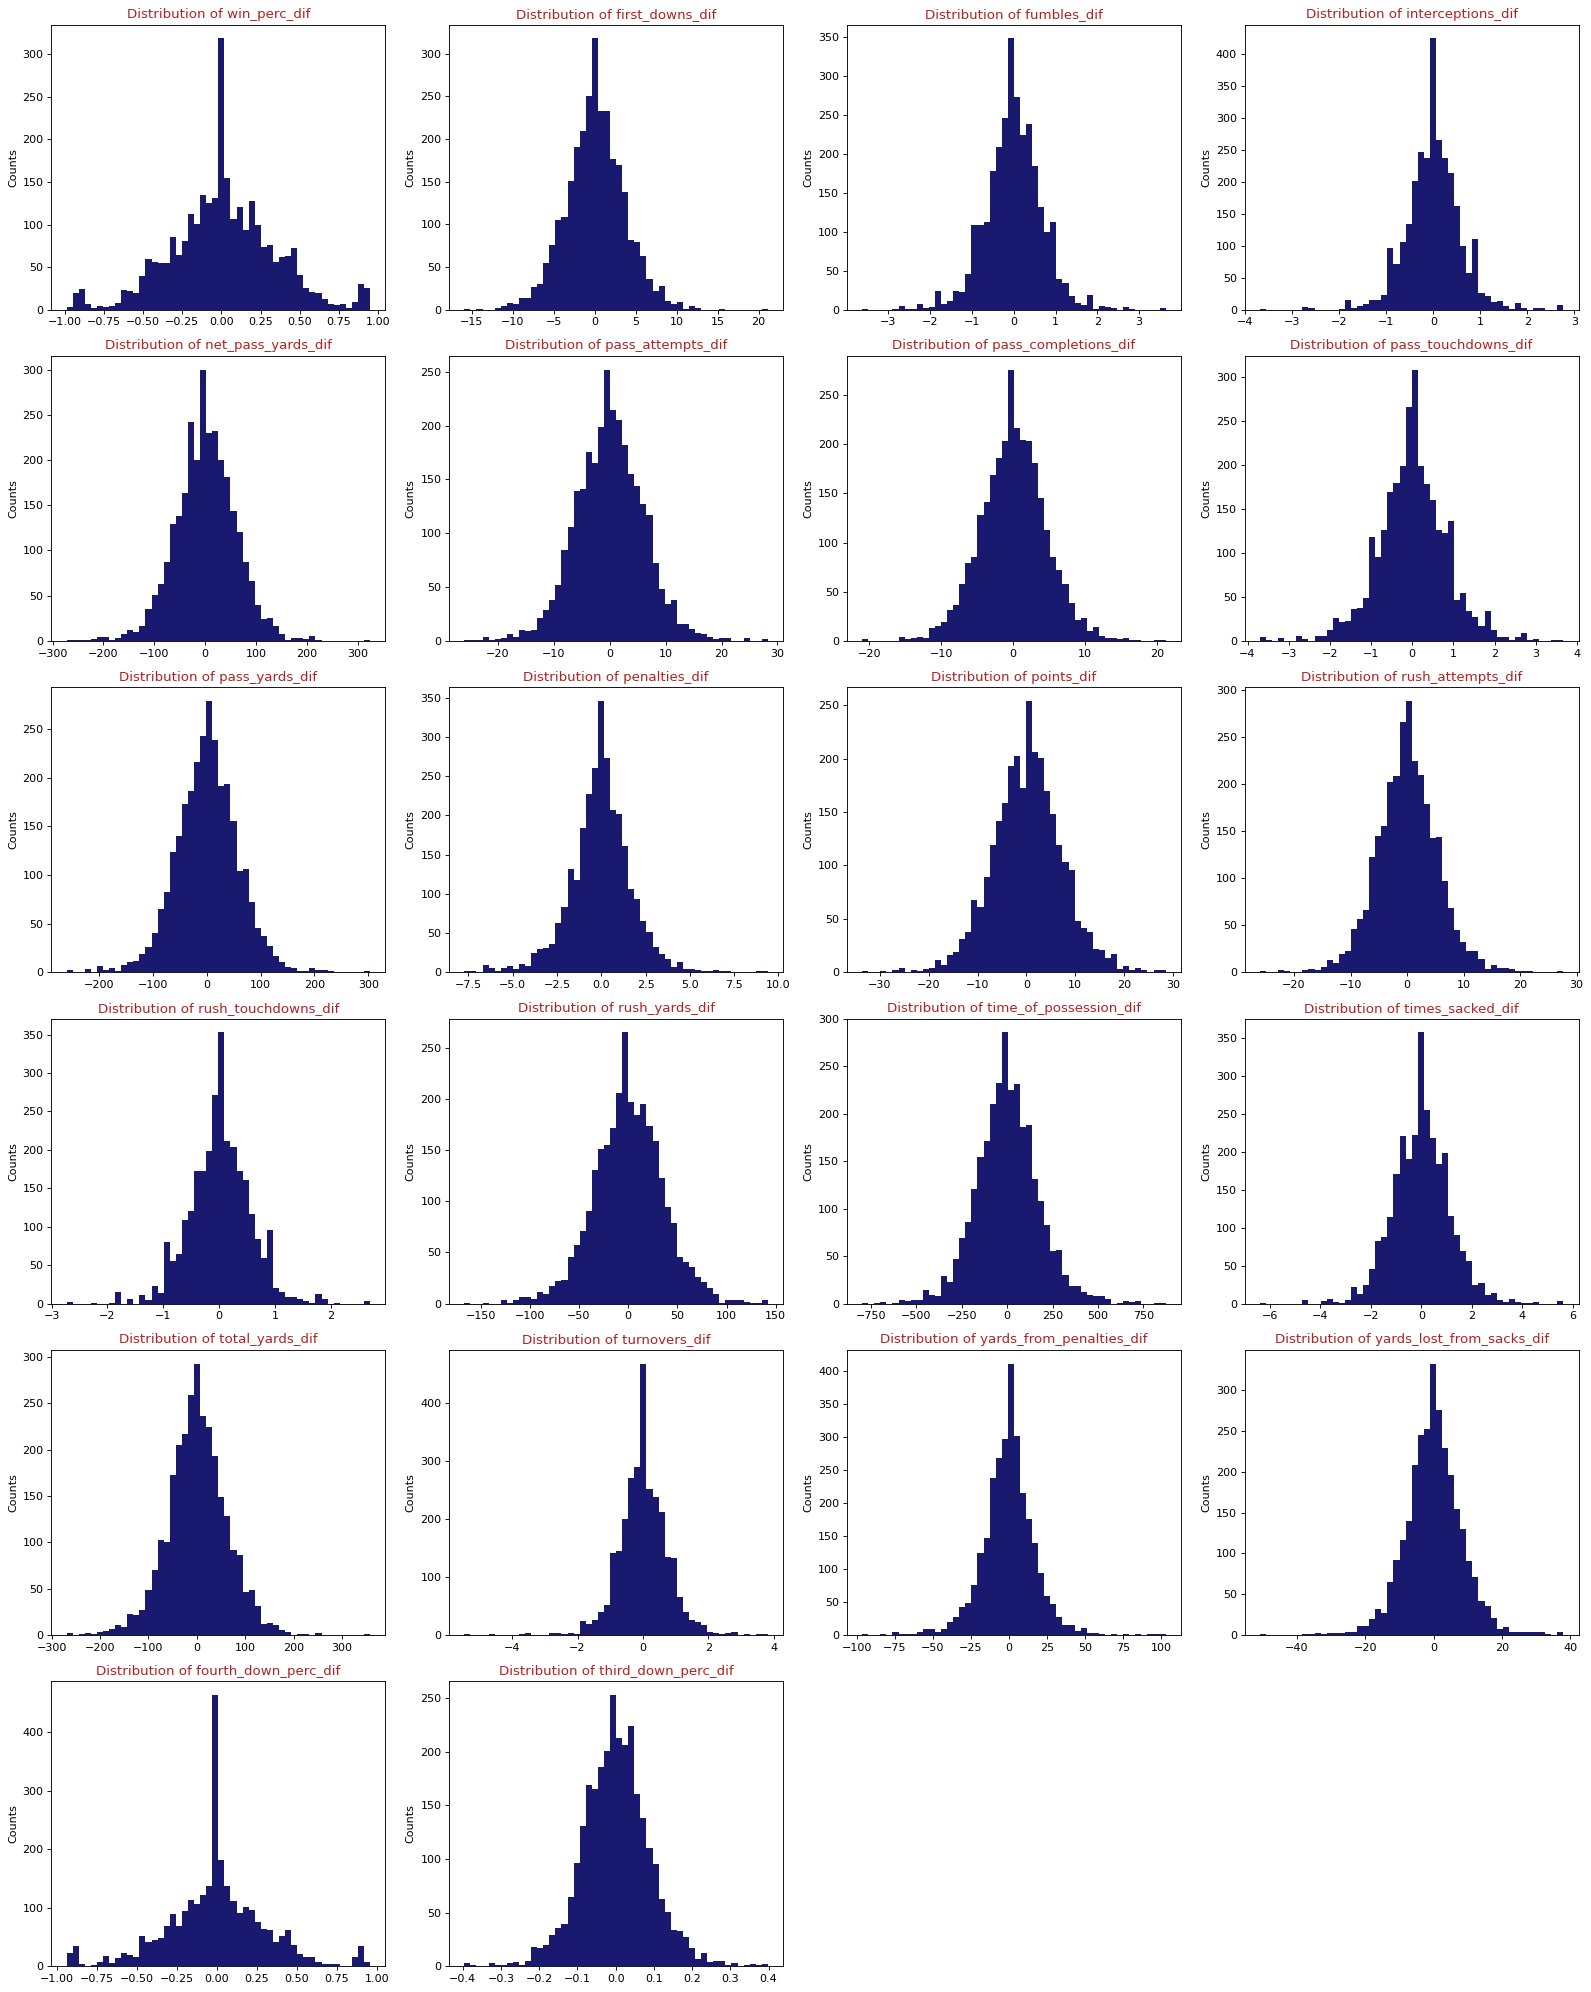

In [82]:
# Creating histogram of the features to visualize the distribution of the data
def create_histograms(model_finding_df, no_of_cols):
    features_df = model_finding_df.iloc[:,6:-1]
    no_of_rows = (len(features_df.columns)//no_of_cols)+1
    fig = plt.figure(figsize=(20,25))
    for i, col in enumerate(features_df.columns):
        ax = fig.add_subplot(no_of_rows,no_of_cols, i+1)
        features_df[col].hist(bins=50, ax=ax, facecolor='midnightblue', grid=False)
        ax.set_title('Distribution of '+col, color='firebrick')
        ax.set_ylabel('Counts')
    fig.tight_layout()  
    plt.show()

create_histograms(model_finding_df, 4)

1. We can see that almost all the data are looking like normal distribution
2. There are some extreme values, but since these numbers are game stats (facts from every game), we believe that we should include all the data to build the models
3. We'll now check the balance of the data because we are building a classification model

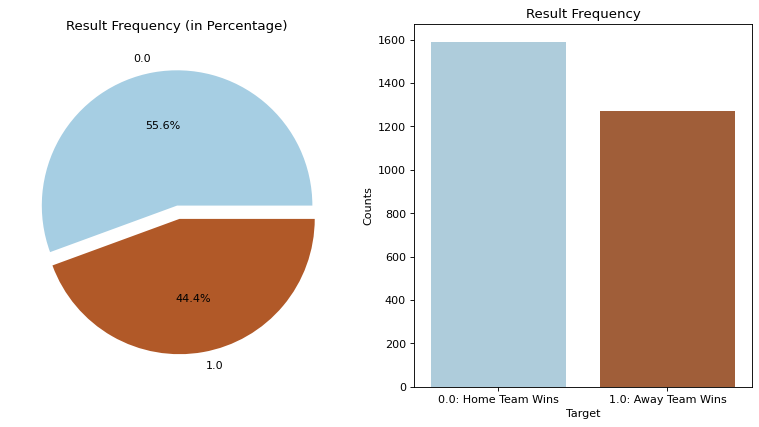

In [83]:
# Checking the balance of the target variable
def create_result_frequency(model_finding_df):
    import seaborn as sns
    fig,axes=plt.subplots(1 , 2, figsize=(12,6), dpi=80)
    model_finding_df['result'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', ax=axes[0], colormap='Paired')
    axes[0].set_title('Result Frequency (in Percentage)')
    axes[0].set_ylabel('')
    sns.countplot('result', data=model_finding_df, ax=axes[1], palette=['#A6CEE3', '#B15928'])
    axes[1].set_title('Result Frequency')
    axes[1].set_ylabel('Counts')
    axes[1].set_xlabel('Target')
    axes[1].set_xticklabels(['0.0: Home Team Wins','1.0: Away Team Wins'])
    plt.show()

create_result_frequency(model_finding_df)

1. The ratio of the target variable (result) is 55.6 : 44.4
2. We think this is a balanced dataset
2. Since it's balanced, we can proceed to check the multicolinearity

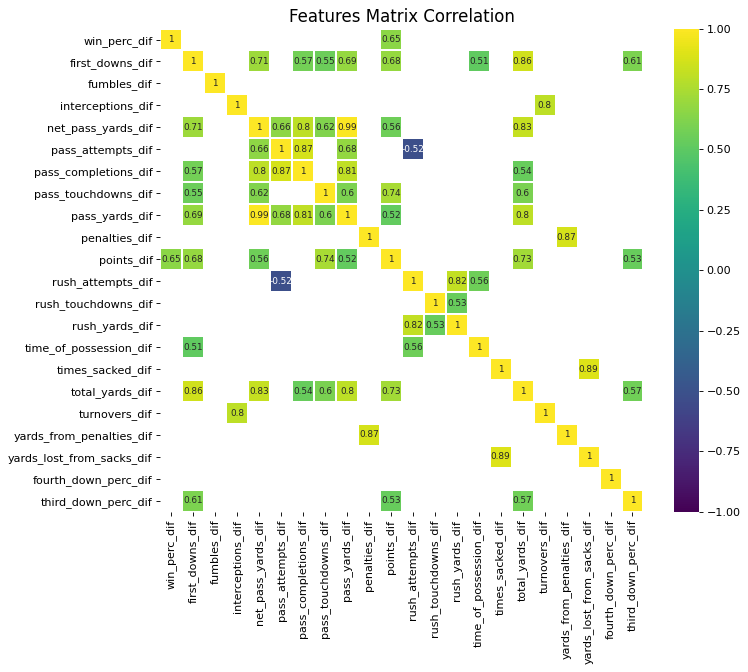

In [84]:
# Checking the correlation matrix
def create_correlation_matrix(model_finding_df):
    features_df = model_finding_df.iloc[:, 6:-1]
    import seaborn as sns
    fig, ax = plt.subplots(figsize=(10, 8), dpi=80)  
    corr_mat = features_df.corr()
    sns.heatmap(corr_mat[(corr_mat >= 0.5) | (corr_mat <= -0.5)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)
    ax.set_title('Features Matrix Correlation', fontsize=15)

create_correlation_matrix(model_finding_df)

1. We can see that there are some features that are highly correlated with each other
2. We will perform PCA to reduce the dimensions (data reductions) to handle this

### 4.2. Building the ML models

#### Steps to build the classification model
1. Separate the data into independent variables (X) and dependent variables (y). Here, 'result' is the dependent variable and rest are independent variables.
2. Splitting the data into train set and test set. Model will learn from the train set and its performance and effectiveness will be tested on the test set.
3. Using StandardScaler to standardise the values corresponding to each independent variable and bring them all in a particular range. We'll perform PCA inside this step too.
4. Importing the model and training the model on the test set
5. Testing the model built on the test set
6. We will be using cross validation to test the ability of our machine learning model to predict new data. It can also help to flag problems like overfitting or selection bias and gives insights on how the model will generalize to an independent dataset.
7. Printing the report (overall effectiveness) including recall, precision, etc of the model

In [85]:
# STEP 1
# Separating the model_finding_df to X and y

X = model_finding_df.iloc[:, 6:-1].values 
y = model_finding_df.iloc[:, -1].values

In [86]:
# STEP 2 
# Splitting the data into train and test

from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [87]:
# STEP 3
# Standardizing the data and performing PCA

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_stdz = sc.fit_transform(X_train_raw)
X_test_stdz = sc.transform(X_test_raw)

print(X_train_stdz.shape)
print(X_test_stdz.shape)

(2146, 22)
(716, 22)


In [88]:
# Performing PCA

from sklearn.decomposition import PCA
dimension = 7 
pca = PCA(n_components = dimension)
X_train = pca.fit_transform(X_train_stdz)
X_test = pca.transform(X_test_stdz)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Total variance explained: {}'.format(pca.explained_variance_ratio_.sum()))

Explained variation per principal component: [0.3046429  0.18971883 0.0892669  0.08019386 0.06881456 0.04553528
 0.04253867]
Total variance explained: 0.820710996064112


In [89]:
# Checking the eigenvalues

eigenvalues = pca.explained_variance_
eigenvalues

array([6.70526833, 4.17576005, 1.96478738, 1.7650874 , 1.51462613,
       1.00224311, 0.93628706])

1. The number of components that we have chosen is 7
2. The reason is that the eigenvalues for 7 components are all > 0.9 (which is close to 1.0)
3. Also, we want to make sure that the total variance explained is at least 80%

In [90]:
# Defining a function to highlight large correlation in the factor loadings table
def highlight_background(val):
    threshold = 0.35
    color = ''
    if (val > threshold) or (val < -1*threshold):
        color = 'wheat'
    return 'background-color: %s' % color

def highlight_font(val):
    threshold = 0.35
    color = ''
    if (val > threshold) or (val < -1*threshold):
        if val > 0:
            color = 'royalblue'
        else:
            color = 'firebrick'
    return 'color: %s' % color

In [91]:
# Using the functions above, we can check which variables explain each component
# Usually, correlation larger than 0.3 (absolute value) is large enough, but we use 0.35 as our threshold
# Column = PCA, Row = Original features

components_df = pd.DataFrame(pca.components_, index=[
    'PCA%i' % i for i in range(dimension)])
components_df = components_df.T.set_index(model_finding_df.iloc[:, 6:-1].columns)
components_style = components_df.style.applymap(highlight_background).applymap(highlight_font)
components_style

,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6
win_perc_dif,0.223113,0.233804,0.095355,0.113964,0.005416,-0.018093,0.255010
first_downs_dif,0.339414,-0.017178,-0.062920,-0.177706,0.146759,-0.010192,-0.110739
fumbles_dif,-0.060636,-0.030725,-0.224603,-0.346287,0.086995,0.222418,0.309752
interceptions_dif,-0.121904,-0.202816,-0.245771,-0.348466,-0.234039,-0.203084,-0.054359
net_pass_yards_dif,0.311251,-0.258107,-0.006438,0.009789,0.030293,0.061491,-0.094640
pass_attempts_dif,0.139138,-0.403265,-0.024018,-0.041475,0.020247,0.023232,-0.007063
pass_completions_dif,0.228418,-0.346574,0.031694,0.001408,0.063024,0.027935,0.013990
pass_touchdowns_dif,0.282182,-0.065270,0.123924,0.132152,-0.000021,-0.171272,0.254412
pass_yards_dif,0.292577,-0.280159,-0.003248,0.008015,0.121070,0.060233,-0.106850
penalties_dif,0.000038,-0.053996,-0.572966,0.383399,0.023891,0.023153,0.089712


1. Component 1 (PCA0): total_yards (+)
2. Component 2 (PCA1): pass_attempts (-), rush_attempts (+), rush_yards (+)
3. Component 3 (PCA2): penalties (-), yards_from_penalties (-)
4. Component 4 (PCA3): fumbles (-), interceptions (-), turnovers (-)
5. Component 5 (PCA4): times_sacked (+), yards_lost_from_sacks (+)
6. Component 6 (PCA5): fourth_down_perc (+)
7. Component 7 (PCA6): rush_touchdowns (+), time_of_possession (-)

In [92]:
# Creating the dataframe for the PCA of training dataset to check the matrix correlation again

pca_X_train_df = pd.DataFrame(data = X_train, columns=[
    'PCA%i' % i for i in range(dimension)])

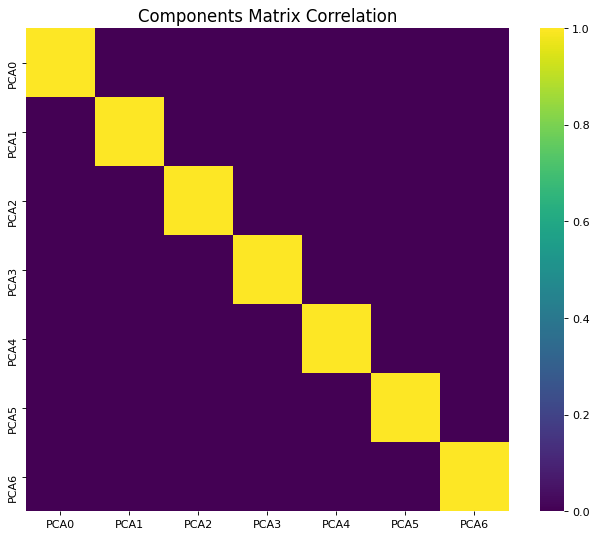

In [93]:
# Creating the correlation matrix for the principal components
def create_pca_correlation_matrix(pca_X_train_df):
    import seaborn as sns
    fig, ax = plt.subplots(figsize=(10, 8), dpi=80)  
    corr_mat = pca_X_train_df.corr()
    sns.heatmap(corr_mat, mask=np.zeros_like(corr_mat, dtype=np.bool),
                cmap='viridis', square=True, ax=ax)
    ax.set_title('Components Matrix Correlation', fontsize=15)

create_pca_correlation_matrix(pca_X_train_df)

1. We can see that we have handled the multicollinearity
2. We can continue with applying several ML models to the datasets (steps 4 to 7 for each  model)

#### Now we are using several machine learning algorithms such as Decision Tree, Logistic Regression , Random Forest Classifier, etc

Steps 1 to 3 (preprocessing steps) as seen above remain same for all the models and we will be building all the models on that dataset

#### Model 1 : Decision Tree

In [ ]:
# STEP 4
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

In [ ]:
# STEP 5 & STEP 6
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report as report
y_pred = classifier.predict(X_test)
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

In [ ]:
# STEP 7
print(report(y_test, y_pred))

#### Model 2 : Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report as report
y_pred = classifier.predict(X_test)
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

In [ ]:
print(report(y_test, y_pred))

#### Model 3 : Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report as report
y_pred = classifier.predict(X_test)
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

In [ ]:
print(report(y_test, y_pred))

#### Model 4 : Kernel SVM (Support Vector Machine)

In [ ]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report as report
y_pred = classifier.predict(X_test)
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

In [ ]:
print(report(y_test, y_pred))

#### Model 5 : Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report as report
y_pred = classifier.predict(X_test)
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

In [ ]:
print(report(y_test, y_pred))

#### Model 6 : KNN (K Nearest Neighbours)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report as report
y_pred = classifier.predict(X_test)
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

In [ ]:
print(report(y_test, y_pred))

#### Model 7 : XGBoost

In [ ]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report as report
y_pred = classifier.predict(X_test)
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

In [ ]:
print(report(y_test, y_pred))

#### Model 8 : Artifical Neural Networks

In [ ]:
import tensorflow as tf
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=7, activation='relu'))
for n in range(2):
    ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
ann.fit(X_train, y_train, batch_size = 32, epochs = 300)

In [ ]:
y_pred = ann.predict(X_test)
y_pred = (y_pred > 0.5)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

In [ ]:
print(report(y_test, y_pred))

### 4.3. Final model selection

#### We choose Logistic Regression Classifier because it has high accuracy and comparable to our models with high accuracy
1. Based on the results above, we can see that Logistic Regression, Kernel SVM, Naive Bayes models and Neural Network have recorded the highest accuracy
2. These four models are also comparable to each other based on the other metrics (precision, recall, etc)
3. We choose Logistic Regression as our model for further analysis as Logistic Regression model gives us accuracy comparable/higher to others. It is also faster to run, efficient to implement compared to other models.
4. With the selected model, we will now take a look at several things: feature importance, confusion matrix, and ROC-AUC
5. Before that, we will run and define the classifier again to make sure we are using the right model

In [94]:
# STEP 1
X = model_finding_df.iloc[:, 6:-1].values
y = model_finding_df.iloc[:, -1].values

# STEP 2
from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# STEP 3
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_stdz = sc.fit_transform(X_train_raw)
X_test_stdz = sc.transform(X_test_raw)

from sklearn.decomposition import PCA
dimension = 7 
pca = PCA(n_components = dimension)
X_train = pca.fit_transform(X_train_stdz)
X_test = pca.transform(X_test_stdz)

# STEP 4
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

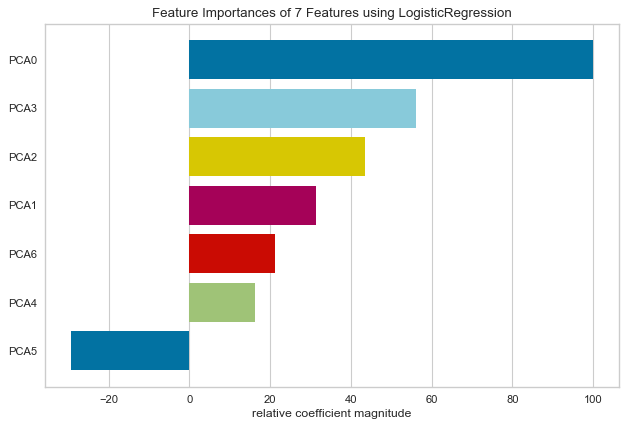

In [95]:
def show_feature_importances(X_test, y_test):
    from yellowbrick.model_selection import feature_importances
    X_test_df = pd.DataFrame(X_test, columns = ['PCA%i' % i for i in range(dimension)])
    y_test_df = pd.DataFrame(y_test, columns = [list(model_finding_df.columns)[-1]])
    classifier = LogisticRegression(C = 0.01, penalty = 'l2', solver = 'liblinear', random_state = 0)
    feature_importances(classifier, X_test_df, y_test_df)
    plt.rcParams["figure.dpi"] = 80
    plt.show()

show_feature_importances(X_test, y_test)

#### Feature importance after PCA
1. As we can see above, PCA0, PCA1, and PCA3 are the top 3 in the feature importance graph
2. If we take a look again at the factor loadings, we know that PCA0 is highly correlated with total_yards (+)
3. PCA1 is highly correlated with pass_attempts (-), rush_attempts (+), and rush_yards (+)
4. And last but not least, PCA3 is highly explained by fumbles (-), interceptions (-), and turnovers (-)
5. The threshold number for absolute correlation between original varibales and the PCA components is 0.35

In [96]:
y_test_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_test_pred)
print('Confusion Matrix:')
print(cm)
print('\nAccuracy: ' + f'{100 * accuracy_score(y_test, y_test_pred):.2f}%')

Confusion Matrix:
[[325  89]
 [174 128]]

Accuracy: 63.27%


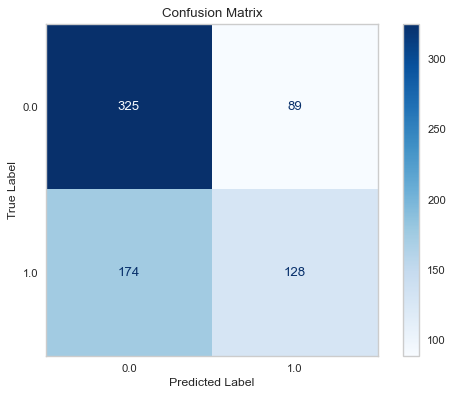

In [97]:
def show_confusion_matrix(classifier, X_test, y_test):
    from sklearn.metrics import plot_confusion_matrix
    matrix = plot_confusion_matrix(classifier, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    plt.grid(visible=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show(matrix)
    plt.rcParams["figure.dpi"] = 80
    plt.show()

show_confusion_matrix(classifier, X_test, y_test)

#### Interpretation of the confusion matrix
1. True negative (tn): model predicts away team lost (0) and away team lost = 295
2. False positive (fp): model predicts away team won (1) but away team actually lost = 92
3. False negative (fn): model predicts away team lost but away team actually won = 171
4. True positive (tp): model predicts away team won and away team won = 128

In [98]:
def show_confusion_matrix_analysis(classifier, X_test, y_test):
    y_test_pred = classifier.predict(X_test)
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_test_pred)
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fpr = fp/(fp+tn)
    f_score = 2*precision*recall/(precision+recall)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    
    print("Precision:\t\t\t%1.2f"%(100*precision) + "% identified as away teams' victory are away teams' victory")
    print("Recall/TPR:\t\t\t%1.2f"%(100*recall) + "% of away teams' victory are identified")
    print("False Positive Rate:\t\t%1.2f"%(100*fpr) + "% of away team's defeat identified as away team's victory")
    print("f-score:\t\t\t%1.2f"%(100*f_score) + "% tradeoff between precision and recall")
    print("Accuracy:\t\t\t%1.2f"%(100*accuracy) + "% how well the model has classified")

show_confusion_matrix_analysis(classifier, X_test, y_test)

Precision:			58.99% identified as away teams' victory are away teams' victory
Recall/TPR:			42.38% of away teams' victory are identified
False Positive Rate:		21.50% of away team's defeat identified as away team's victory
f-score:			49.33% tradeoff between precision and recall
Accuracy:			63.27% how well the model has classified


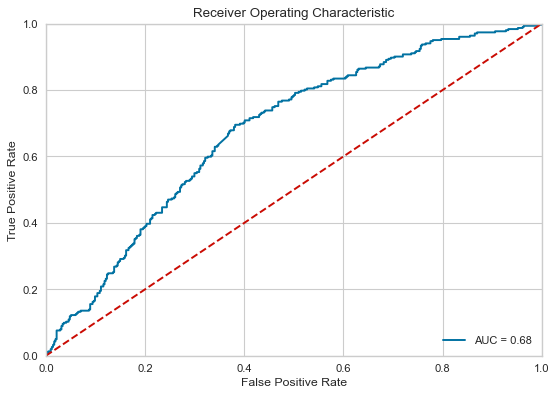

In [99]:
def show_roc_curve(classifier, X_test, y_test):
    import sklearn.metrics as metrics
    y_test_pred_prob = classifier.predict_proba(X_test)
    y_test_pred_prob = y_test_pred_prob[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_test_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.rcParams["figure.dpi"] = 80
    plt.show()

show_roc_curve(classifier, X_test, y_test)

1. The area under curve (AUC) is 0.68
2. The AUC is a measure of how stable the model is
3. If the AUC is higher, then the better the model is at predicting 0 classes as 0 and 1 classes as 1
4. We consider the 0.68 value is good enough for this use-case

#### Feature importance with original full features
1. We have obtained the feature importance from the model after PCA
2. However, to be able to compare it the previous hypothesis of good features and bad features, we need the feature importance with original full features instead
3. To do that, we run the best model (Logistic Regression) on the dataset without performing PCA so the dimension is not reduced
4. When building this particular model, we add 'F' or 'f' to the variable or model name to indicate 'full features', and so that it won't change the value of pre-defined variables that have been used before

In [100]:
# STEP 1
XF = model_finding_df.iloc[:, 6:-1].values
yf = model_finding_df.iloc[:, -1].values

# STEP 2
from sklearn.model_selection import train_test_split
XF_train_raw, XF_test_raw, yf_train, yf_test = train_test_split(XF, yf, test_size = 0.25, random_state = 0)

# STEP 3
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
XF_train = sc.fit_transform(XF_train_raw)
XF_test = sc.transform(XF_test_raw)

# STEP 4
from sklearn.linear_model import LogisticRegression
classifier_f = LogisticRegression(random_state = 0)
classifier_f.fit(XF_train, yf_train)

LogisticRegression(random_state=0)

#### GridSearchCV method is used for hyperparameter tuning so that the best parameters are selected for the Logistic Regression

In [101]:
from sklearn.model_selection import GridSearchCV
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
parameters = dict(solver=solvers,penalty=penalty,C=c_values)
# parameters = {'var_smoothing': np.logspace(0,-9, num=100)}
grid_search = GridSearchCV(estimator = classifier_f,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search.fit(XF_train, yf_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Parameters:", best_parameters)

Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}


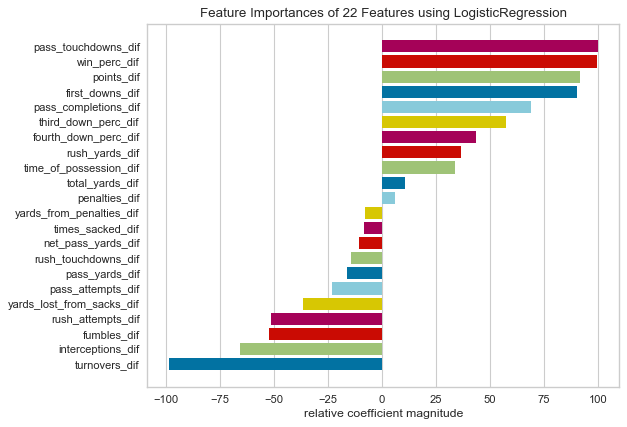

In [102]:
def show_feature_importances_full_features(XF_test, yf_test):
    from yellowbrick.model_selection import feature_importances
    XF_test_df = pd.DataFrame(XF_test, columns = list(model_finding_df.columns)[6:-1])
    yf_test_df = pd.DataFrame(yf_test, columns = [list(model_finding_df.columns)[-1]])
    classifier_f = LogisticRegression(C = 0.01, penalty = 'l2', solver = 'liblinear', random_state = 0)
    feature_importances(classifier_f, XF_test_df, yf_test_df)
    plt.rcParams["figure.dpi"] = 80
    plt.show()

show_feature_importances_full_features(XF_test, yf_test)

1. If we compare with our previous hypothesis, there are five features where feature importance shows different results
2. Feature importance shows that penalties has positive importance while we hypothesized that this feature is a bad feature instead
3. Feature importance shows that total_yards, net_pass_yards, pass_yards, and rush_attempts has negative importance while we hypothesized that they are good features instead
4. Based on these results, we believe that we still can accept our hypothesis
5. We can say that our intuition about good attributes (features) and bad attributes is in line with the feature importance results, even though there are some exceptions

## 5. NFL Games Prediction

### 5.1. Predicting probabilities for the current week games that have not been played yet

1. Using the selected classifier, we can now predict the outcome of forthcoming games in the current week that have not been played
2. We first define a function to display the prediction results
3. After that, we define the dataset that will be used from the prediction dataframe we have created before
4. The dataset is then standardized and transformed according to the PCA results
5. Finally, we can compute the winning probability of the away team and display the results

In [103]:
# Function to display the prediction results
def display_prediction_for_current_week_games(y_pred_prob, prediction_df):
    for t in range(len(y_pred_prob)):
        win_prob = round(y_pred_prob[t], 3)
        away_team = prediction_df.reset_index().drop(columns = 'index').loc[t,'away_name']
        home_team = prediction_df.reset_index().drop(columns = 'index').loc[t,'home_name']
        print('The {} have a probability of {} of defeating the {}.'.format(away_team, win_prob, home_team))

In [104]:
# Define and transform the dataset
X_pred_raw = prediction_df.iloc[:, 6:-1].values
X_pred_stdz = sc.transform(X_pred_raw)
X_pred = pca.transform(X_pred_stdz)

In [106]:
# Predict the results (winning probability)
y_pred_prob = classifier.predict_proba(X_pred)
y_pred_prob = y_pred_prob[:,1]

In [108]:
display_prediction_for_current_week_games(y_pred_prob, prediction_df)

The Buffalo Bills have a probability of 0.441 of defeating the Los Angeles Rams.
The New Orleans Saints have a probability of 0.55 of defeating the Atlanta Falcons.
The Cleveland Browns have a probability of 0.528 of defeating the Carolina Panthers.
The San Francisco 49ers have a probability of 0.591 of defeating the Chicago Bears.
The Pittsburgh Steelers have a probability of 0.392 of defeating the Cincinnati Bengals.
The Philadelphia Eagles have a probability of 0.577 of defeating the Detroit Lions.
The Indianapolis Colts have a probability of 0.634 of defeating the Houston Texans.
The New England Patriots have a probability of 0.545 of defeating the Miami Dolphins.
The Baltimore Ravens have a probability of 0.591 of defeating the New York Jets.
The Kansas City Chiefs have a probability of 0.472 of defeating the Arizona Cardinals.
The Green Bay Packers have a probability of 0.511 of defeating the Minnesota Vikings.
The New York Giants have a probability of 0.299 of defeating the Tenn

### 5.2. Simple text mining (sentiment analysis) vs. machine learning model
1. We know that NFL is the number 1 sport in the US
2. Fans, sports analysts, or media in general will report a news, share an analysis, or just give a support about the NFL teams
3. One medium where they'll do it is Twitter
4. We will gather the recent tweets from Twitter using each team's name as the search term
5. After that we will perform sentiment analysis on each team's search results
6. For each pair of two teams that will play each other in the current week, we'll compute the net sentiment score (net_sentiment_dif), which is the difference of the net sentiment of the away team minus that of the home team
7. If the net sentiment is greater than 0, then we'll just simply conclude that the away team is more favoured, and vice versa
8. We can then compare it with the probability model results since we can know which team is more favoured to win the game based on the winning probability of the away team

In [ ]:
# Function to do the positive vs. negative sentiment analysis
def do_pos_neg_sentiment_analysis(text_list, debug=False):
    import nltk
    def get_pos_neg_words():
        
        def get_words(url):
            import requests
            words = requests.get(url).content.decode('latin-1')
            word_list = words.split('\n')
            index = 0
            while index < len(word_list):
                word = word_list[index]
                if ';' in word or not word:
                    word_list.pop(index)
                else:
                    index+=1
            return word_list

        p_url = 'http://ptrckprry.com/course/ssd/data/positive-words.txt'
        n_url = 'http://ptrckprry.com/course/ssd/data/negative-words.txt'
        positive_words = get_words(p_url)
        negative_words = get_words(n_url)
        return positive_words, negative_words
    
    positive_words, negative_words = get_pos_neg_words()
    from nltk import word_tokenize
    sentiment_results = list()
    for text in text_list:
        cpos = cneg = lpos = lneg = 0
        for word in word_tokenize(text[1]):
            if word in positive_words:
                if debug:
                    print("Positive", word)
                cpos+=1
            if word in negative_words:
                if debug:
                    print("Negative", word)
                cneg+=1
        sentiment_results.append((text[0], cpos/len(word_tokenize(text[1])),
                                  cneg/len(word_tokenize(text[1]))))
    return sentiment_results

In [ ]:
# Function to get the recent tweets that will be used as an input to the sentiment analysis function
def get_recent_tweets(search_term):
    
    # Change the twitter API input
    consumer_key = 'nfTyujbaEl1fDF22xVlMYz6ga'
    consumer_secret = 'NinKRYzhB5LQevBg7a5H38SZIoDdDFHsvqgQWFdBi5Ir2Bz6qP'
    access_token = '1456748024533856263-3TENqcDwMAamVNd4wEKpa8jxNgEsEf'
    access_token_secret = 'u8F5lNFuPfqQ2gZtS81mLSLkoAQikBeFUA7JNy4Gfqvg9'
    
    # Change this to your computer directory
    file_location = 'C:/Data/03_MSBA/05_Courses_Term/01_Fall_2021/IEOR_E_4523_DA/Group_Project/Notebook_Files/Tweets/'
    
    import tweepy
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth)

    tweet_results = api.search_tweets(q=search_term,
                                      lang='en',
                                      result_type='recent',
                                      count=1000)

    for i in range(len(tweet_results)):
        filename = search_term+'.'+str(len(tweet_results)-i)
        with open(file_location+filename, 'w', encoding='utf-8') as f:
            f.write(tweet_results[i]._json['text']+'\n')

In [ ]:
def compare_probability_model_and_sentiment(prediction_df, y_pred_prob):
    prediction_df = prediction_df.reset_index().drop(columns='index')

    probability_final_list = list()
    
    for i in prediction_df.index:
        if y_pred_prob[i] > 0.5:
            probability_winner = prediction_df['away_name'][i]
        elif y_pred_prob[i] < 0.5:
            probability_winner = prediction_df['home_name'][i]
        else:
            probability_winner = 'Draw'

        probability_final_list.append([prediction_df['away_name'][i],
                                   prediction_df['home_name'][i],
                                   f'{y_pred_prob[i]:.2f}',
                                   probability_winner])
    
    sentiment_final_list = list()

    for i in prediction_df.index:
        get_recent_tweets(prediction_df['away_name'][i])
        get_recent_tweets(prediction_df['home_name'][i])
    
        # Change this to your computer directory where the tweets data are stored
        tweets_root = 'C:/Data/03_MSBA/05_Courses_Term/01_Fall_2021/IEOR_E_4523_DA/Group_Project/Notebook_Files/Tweets'
    
        import nltk
        from nltk.corpus import PlaintextCorpusReader
        
        away_files = prediction_df['away_name'][i]+'.*'
        home_files = prediction_df['home_name'][i]+'.*'
        away_data = PlaintextCorpusReader(tweets_root, away_files)
        home_data = PlaintextCorpusReader(tweets_root, home_files)
    
        sentiment_list = do_pos_neg_sentiment_analysis([[prediction_df['away_name'][i],
                                                         away_data.raw()],
                                                        [prediction_df['home_name'][i],
                                                         home_data.raw()]])
    
        away_net = (sentiment_list[0][1] - sentiment_list[0][2])
        home_net = (sentiment_list[1][1] - sentiment_list[1][2])
        net_sentiment_dif = 100 * (away_net - home_net)
    
        if net_sentiment_dif > 0:
            sentiment_winner = prediction_df['away_name'][i]
        elif net_sentiment_dif < 0:
            sentiment_winner = prediction_df['home_name'][i]
        else:
            sentiment_winner = 'Draw'
    
        sentiment_final_list.append([sentiment_list[0][0],
                                     sentiment_list[1][0],
                                     f'{net_sentiment_dif:.2f}%',
                                     sentiment_winner])
    
    probability_df = pd.DataFrame(probability_final_list, columns = ['away_name',
                                                                     'home_name',
                                                                     'away_win_prob',
                                                                     'favourable_team_prob'])
    
    sentiment_df = pd.DataFrame(sentiment_final_list, columns = ['away_name',
                                                                 'home_name',
                                                                 'away_minus_home_net_sentiment',
                                                                 'favourable_team_sentiment'])
    
    prob_model_vs_sentiment_df = pd.merge(probability_df, sentiment_df,
                                          left_on=['away_name', 'home_name'],
                                          right_on=['away_name', 'home_name'])
   
    return prob_model_vs_sentiment_df

In [ ]:
# Calling the main function to create the comparison dataframe
prob_model_vs_sentiment_df = compare_probability_model_and_sentiment(prediction_df, y_pred_prob)

1. The favourable_team_prob is equal to away_name if the away_win_prob is greater than 0.5
2. The favourable_team_prob is equal to home_name if the away_win_prob is smaller than 0.5
3. The favourable_team_sentiment is equal to away_name if the away_minus_home_net_sentiment is greater than 0%
4. The favourable_team_sentiment is equal to home_name if the away_minus_home_net_sentiment is smaller than 0%

In [ ]:
prob_model_vs_sentiment_df

#### In this analysis and comparison, we have some assumptions
1. We assume the recent tweets will reflect the upcoming game that a particular team will play, meaning that the tweets leading up to the match will be about the match: who will win and who will lose (while in reality, the tweets are not always about the upcoming game)
2. We assume that greater net sentiment means that there are more favourable tweets on that team to win the game against the other team, even though both teams have recorded positive net sentiment

In [ ]:
prob_model_vs_sentiment_df[prob_model_vs_sentiment_df['favourable_team_prob']
                           == prob_model_vs_sentiment_df['favourable_team_sentiment']]

1. We can filter the dataframe to select all the rows where both the favourable teams (one is based on the model and the other one is based on the sentiment analysis) are equal
2. It is also important to note that the tweets data are always being updated since new tweets appear from time to time, and thus the sentiment analysis results may change accordingly